In [23]:
# Import Libraries
import string
import contractions
import pickle
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Load Dataset
def Load_Dataset(filename):
  try:
    with open(filename, 'r') as file:
      print('Dataset in use:\t', file.name)
      documents = []
      for i, line in enumerate(file):
        if(i%3==1):
          question = line  # Question
        elif(i%3==2):
          answer = line  # Answer
          documents.append([feature, question, answer])
        else:
          feature = int(line) # Question 
      pass
    return documents
  except FileNotFoundError:
    print("File \'{}\' not found.".format(filename))
  except:
    print("An error occurred while accessing the file.")

In [25]:
def Clean_Tokenize(sentence):
  # Characters to be removed
  ignore_letters = '!"#$%&\'()*+,-./:;=?@[\]^_`{|}~`<>\n'
  # Tokenize question while panctuation and EOL exluded
  words = nltk.word_tokenize(contractions.fix(sentence.lower()).translate(str.maketrans("", "", ignore_letters)))
  
  if('<PAD>' in sentence):
    words[words.index('pad')] = '<PAD>'
  
  # Lemmatize list's words
  words = [lemmatizer.lemmatize(word) for word in words]
  return words

In [26]:
# Create Vocabulary
def Create_Vocabulary(documents):
  vocabulary = ['<PAD>']
  for document in documents:
    # Lemmatize question's words
    words = Clean_Tokenize(document[1])
    #Add words to Vocabulary
    for word in words:
      if(word not in vocabulary):
        vocabulary.append(word)
  return vocabulary

In [27]:
# Mapping Dictionary
def Mapping_Dictionary(documents, vocabulary):
  mapping_dictionary = []
  mapping_question = []
  for document in documents:
    for token in document[3]:
      try:
        mapping_question.append(vocabulary.index(Clean_Tokenize(token)[0]))
      except ValueError:
        # Handle the case where the token is not in the vocabulary
        print(token, Clean_Tokenize(token)[0], document[3])
    mapping_dictionary.append(sorted(mapping_question.copy(), reverse=True))
    mapping_question.clear()
  return mapping_dictionary

In [28]:
def One_Hot_Features(documents, FEATURES_NUM):
  one_hot_features = []
  for ft in documents:
    one_hot_feature = [0] * FEATURES_NUM
    one_hot_feature[int(ft[0])] = 1
    one_hot_features.append(one_hot_feature.copy())
    one_hot_feature.clear()
  return one_hot_features

In [29]:
# Initialization

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Lists
questions = []
answers = []
vocabulary = []
documents = []
feature = []
FEATURES_NUM = 267

In [30]:
# Load Training Data
train_docs = Load_Dataset('/content/drive/MyDrive/_PTYXIAKI/RUN_3/training_data_3.txt')

# Load Validation Data
val_docs = Load_Dataset('/content/drive/MyDrive/_PTYXIAKI/RUN_3/validation_data_3.txt')

Dataset in use:	 /content/drive/MyDrive/_PTYXIAKI/RUN_3/training_data_3.txt
Dataset in use:	 /content/drive/MyDrive/_PTYXIAKI/RUN_3/validation_data_3.txt


In [ ]:
# Create Vocabulary
all_docs = train_docs.copy()
all_docs.extend(val_docs)
vocabulary = Create_Vocabulary(all_docs)

In [32]:

train_documents = [x.copy()+[Clean_Tokenize(x[1])] for x in train_docs]
val_documents = [x.copy()+[Clean_Tokenize(x[1])] for x in val_docs]

# Map Data
train_data_map = Mapping_Dictionary(train_documents, vocabulary)
val_data_map = Mapping_Dictionary(val_documents, vocabulary)

train_features = One_Hot_Features(train_documents, FEATURES_NUM)
val_features = One_Hot_Features(val_documents, FEATURES_NUM)

In [33]:
all_docs = [x.copy()+[Clean_Tokenize(x[1])] for x in all_docs]
MAXLEN = len(max(np.array(all_docs, dtype=object)[:,3]))
if(len(max(np.array(all_docs, dtype=object)[:,3]))<25):
  MAXLEN = 25

pickle.dump(MAXLEN, open('/content/drive/MyDrive/_PTYXIAKI/MAXLEN_4.pkl', 'wb'))
pickle.dump(vocabulary, open('/content/drive/MyDrive/_PTYXIAKI/vocabulary_4.pkl', 'wb'))
#pickle.dump(np.array(documents)[:, 1].tolist(), open('classes.pkl', 'wb'))

#Zero Padding
train_padded_sequences = pad_sequences(train_data_map, padding='post', maxlen=MAXLEN)
val_padded_sequences = pad_sequences(val_data_map, padding='post', maxlen=MAXLEN)

In [34]:
np.array(all_docs)[:, 0]

<ipython-input-34-947e8195fc6d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(all_docs)[:, 0]


array([169, 254, 173, ..., 95, 151, 123], dtype=object)

In [ ]:
# Define the Model
# Embedding layer
# LSTM layer
# Dense layer with softmax activation function
'''
model = tf.keras.models.Sequential([
tf.keras.layers.Input(shape=(MAXLEN,)),
tf.keras.layers.Embedding(input_dim=len(documents), output_dim=100, input_length=MAXLEN),
tf.keras.layers.LSTM(units=len(documents)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=len(documents), activation='softmax')])
'''
'''
model = Sequential()
model.add(Embedding(input_dim=len(documents), output_dim=64, input_length=MAXLEN))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(62, dropout=0.1, recurrent_dropout=0.1)) #
model.add(Dense(int(len(documents)/4), activation='softmax'))
'''
model = Sequential()
model.add(Embedding(input_dim=len(train_padded_sequences), output_dim=100, input_length=MAXLEN))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model.add(Dense(FEATURES_NUM, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=np.array(train_padded_sequences), y=np.array(train_features), epochs=1000, validation_data=(np.array(val_padded_sequences), np.array(val_features)), batch_size=25)

model.save('/content/drive/MyDrive/_PTYXIAKI/MODEL_KATHARO/chatbot_model_4.h5')
pickle.dump(history, open('/content/drive/MyDrive/_PTYXIAKI/MODEL_KATHARO/history_4.pkl', 'wb'))
model.summary()

Epoch 1/1000
274/274 [==============================] - 30s 86ms/step - loss: 5.7769 - accuracy: 0.0029 - val_loss: 5.5881 - val_accuracy: 0.0056
Epoch 2/1000
274/274 [==============================] - 21s 77ms/step - loss: 4.7981 - accuracy: 0.0205 - val_loss: 4.1869 - val_accuracy: 0.0356
Epoch 3/1000
274/274 [==============================] - 23s 85ms/step - loss: 4.1037 - accuracy: 0.0340 - val_loss: 3.8291 - val_accuracy: 0.0412
Epoch 4/1000
274/274 [==============================] - 22s 79ms/step - loss: 3.8852 - accuracy: 0.0380 - val_loss: 3.6717 - val_accuracy: 0.0431
Epoch 5/1000
274/274 [==============================] - 24s 88ms/step - loss: 3.7162 - accuracy: 0.0469 - val_loss: 3.5459 - val_accuracy: 0.0581
Epoch 6/1000
274/274 [==============================] - 23s 84ms/step - loss: 3.6341 - accuracy: 0.0500 - val_loss: 3.4314 - val_accuracy: 0.0730
Epoch 7/1000
274/274 [==============================] - 26s 96ms/step - loss: 3.5837 - accuracy: 0.0525 - val_loss: 3.3612 -

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/_PTYXIAKI/model_4_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/_PTYXIAKI/model_4_loss.png')
plt.show()


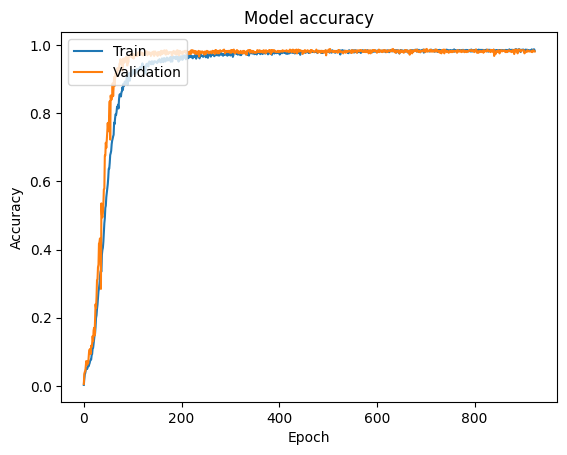

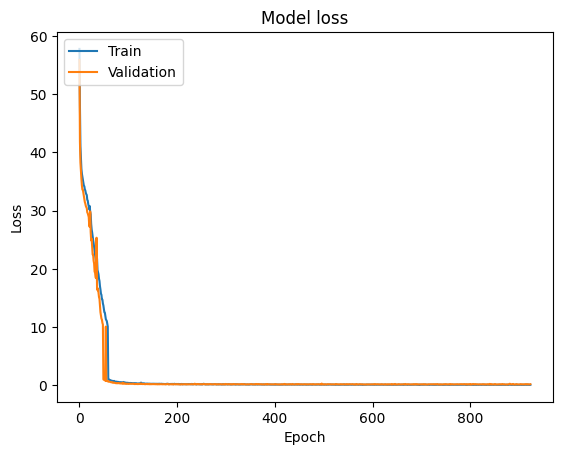

In [2]:
import matplotlib.pyplot as plt
'''
history = {"loss": [60.049, 55.584, 50.394, 46.084, 43.635, 41.551, 40.186, 39.520, 38.751, 37.617, 37.232, 36.509, 35.945, 36.021, 35.233, 34.683, 34.297, 33.997, 33.572, 33.366, 32.856, 33.527, 32.331, 32.024, 31.841, 31.298, 31.341, 31.204, 30.603, 30.082, 30.064, 29.584, 29.313, 29.340, 29.050, 28.650, 28.220, 27.753, 27.805, 27.185, 26.721, 26.484, 25.533, 25.642, 25.237, 24.607, 24.227, 23.584, 23.265, 23.045, 22.731, 22.193, 21.621, 21.294, 21.350, 20.760, 19.974, 20.119, 19.512, 19.155, 19.153, 18.550, 17.684, 17.681, 17.122, 16.999, 16.324, 16.013, 15.577, 15.663, 14.983, 14.752, 14.592, 13.990, 13.553, 13.742, 13.303, 13.797, 13.046, 12.206, 12.688, 11.872, 11.830, 10.950, 10.954, 10.852, 10.939, 10.280, 10.000, 0.9937, 0.9607, 0.9794, 0.9616, 0.9317, 0.9734, 0.8813, 0.8404, 0.8562, 0.8129, 0.9270, 0.8395, 0.7847, 0.7281, 0.7495, 0.7399, 0.7381, 0.7263, 0.7245, 0.6764, 0.6359, 0.6507, 0.6138, 0.5996, 0.5949, 0.5792, 0.5567, 0.5481, 0.5657, 0.5391, 0.5415, 0.6375, 0.5757, 0.5161, 0.4919, 0.4998, 0.5480, 0.4902, 0.4881, 0.4574, 0.4342, 0.4446, 0.4477, 0.4439, 0.4303, 0.4498, 0.4096, 0.3833, 0.3991, 0.4005, 0.3941, 0.3716, 0.4195, 0.3543, 0.3539, 0.3579, 0.3206, 0.3258, 0.3260, 0.3048, 0.3380, 0.3294, 0.3320, 0.3290, 0.3305, 0.3344, 0.3187, 0.3115, 0.3049, 0.2998, 0.4663, 0.4457, 0.3632, 0.3232, 0.2925, 0.2898, 0.2687, 0.2731, 0.2585, 0.2667, 0.2922, 0.2605, 0.2388, 0.2506, 0.2507, 0.2533, 0.2716, 0.2214, 0.2429, 0.2646, 0.2185, 0.2772, 0.2306, 0.2292, 0.2519, 0.2844, 0.2093, 0.2076, 0.2223, 0.2285, 0.2104, 0.2136, 0.1808, 0.1907, 0.2157, 0.1981, 0.2181, 0.2070, 0.2665, 0.4256, 0.3625, 0.2640, 0.2428, 0.2537, 0.2020, 0.1957, 0.2046, 0.2106, 0.1929, 0.1976, 0.2341, 0.1811, 0.2153, 0.1512, 0.1881, 0.2178, 0.1946, 0.1687, 0.2707, 0.1851, 0.2033, 0.1549, 0.1754, 0.1499, 0.1805, 0.1655, 0.1955, 0.2288, 0.2176, 0.1752, 0.2175, 0.1833, 0.1736, 0.1755, 0.1446, 0.1765, 0.1607, 0.1549, 0.1487, 0.1449, 0.1753, 0.2184, 0.1815, 0.1721, 0.1312, 0.1418, 0.1447, 0.1325, 0.1433, 0.1610, 0.1770, 0.1990, 0.1914, 0.1658, 0.1363, 0.1377, 0.1676, 0.1668, 0.3071, 0.2467, 0.1865, 0.1735, 0.1725, 0.1443, 0.1307, 0.1374, 0.1521, 0.1462, 0.1440, 0.1126, 0.1366, 0.1510, 0.1441, 0.1033, 0.1131, 0.1484, 0.1478, 0.1457, 0.1398, 0.1552, 0.1355, 0.1584, 0.1289, 0.1383, 0.1196, 0.1573, 0.1121, 0.1136, 0.1872, 0.1496, 0.1433, 0.1433, 0.1205, 0.1051, 0.1245, 0.1453, 0.1017, 0.1071, 0.2045, 0.1431, 0.1454, 0.1353, 0.1110, 0.0967, 0.1339, 0.3612, 0.4259, 0.1886, 0.1942, 0.1469, 0.1404, 0.1179, 0.1232, 0.1284, 0.1131, 0.1041, 0.1185, 0.1569, 0.1342, 0.1176, 0.1056, 0.2202, 0.1420, 0.1243, 0.1304, 0.1066, 0.1179, 0.1380, 0.1020, 0.1043, 0.1270, 0.1150, 0.1146, 0.1226, 0.1027, 0.0971, 0.0990, 0.1776, 0.1387, 0.1192, 0.1174, 0.0896, 0.0832, 0.0988, 0.1021, 0.1239, 0.1494, 0.1653, 0.1174, 0.1200, 0.1042, 0.1107, 0.0994, 0.0715, 0.0686, 0.0859, 0.0946, 0.1318, 0.1019, 0.1050, 0.1298, 0.0876, 0.1175, 0.1529, 0.1527, 0.1260, 0.0994, 0.2006, 0.1104, 0.1209, 0.1010, 0.0951, 0.0909, 0.1125, 0.0960, 0.1005, 0.0841, 0.0750, 0.0809, 0.0839, 0.0856, 0.0813, 0.1060, 0.1767, 0.1540, 0.1273, 0.1147, 0.0923, 0.0811, 0.0896, 0.0871, 0.1100, 0.1326, 0.1082, 0.0925, 0.1209, 0.0914, 0.0922, 0.0719, 0.0882, 0.0739, 0.0821, 0.1045, 0.0956, 0.0926, 0.0979, 0.1563, 0.0877, 0.0823, 0.0971, 0.0814, 0.1159, 0.1288, 0.1330, 0.0786, 0.0697, 0.0866, 0.1047, 0.1261, 0.1061, 0.0802, 0.1023, 0.0932, 0.1086, 0.0861, 0.0907, 0.0882, 0.1160, 0.0742, 0.0673, 0.0595, 0.1071, 0.2093, 0.1134, 0.0735, 0.0675, 0.0838, 0.0881, 0.0770, 0.0937, 0.0871, 0.0671, 0.1064, 0.0952, 0.1090, 0.1039, 0.0837, 0.0961, 0.0949, 0.0861, 0.0679, 0.0715, 0.0883, 0.0730, 0.1052, 0.0704, 0.0622, 0.0813, 0.2864, 0.1626, 0.1054, 0.0917, 0.0890, 0.0874, 0.0977, 0.0868, 0.0993, 0.0732, 0.0933, 0.0935, 0.0899, 0.0751, 0.1130, 0.0774, 0.0793, 0.1038, 0.0753, 0.0609, 0.1610, 0.1146, 0.1078, 0.1114, 0.0809, 0.0728, 0.0798, 0.0666, 0.0857, 0.0626, 0.1272, 0.1097, 0.0842, 0.0751, 0.0762, 0.0995, 0.0587, 0.0513, 0.0788, 0.0888, 0.0567, 0.0869, 0.0733, 0.0830, 0.0805, 0.0615, 0.0644, 0.0692, 0.0712, 0.1631, 0.1309, 0.0950, 0.0597, 0.0624, 0.0554, 0.0721, 0.1005, 0.0675, 0.0794, 0.0913, 0.1087, 0.0674, 0.0635, 0.0700, 0.0909, 0.0743, 0.0771, 0.0792, 0.0591, 0.0688, 0.0720, 0.0583, 0.0747, 0.1547, 0.1031, 0.0987, 0.0873, 0.0671, 0.0612, 0.0647, 0.0742, 0.0644, 0.0659, 0.0556, 0.0956, 0.0748, 0.0772, 0.0741, 0.1291, 0.1418, 0.0980, 0.0723, 0.0653, 0.0632, 0.0578, 0.0547, 0.0567, 0.0609, 0.0489, 0.1008, 0.0986, 0.0789, 0.0746, 0.0636, 0.0597, 0.0507, 0.0556, 0.0741, 0.0778, 0.0776, 0.0553, 0.0670, 0.0861, 0.0824, 0.0664, 0.0630, 0.0818, 0.0520, 0.0597, 0.0772, 0.0729, 0.0500, 0.0884, 0.1213, 0.0800, 0.0859, 0.0715, 0.0594, 0.0486, 0.0420, 0.0521, 0.1149, 0.0849, 0.0735, 0.0652, 0.0720, 0.0759, 0.0553, 0.0540, 0.0484, 0.0469, 0.0676, 0.1173, 0.1077, 0.0728, 0.0583, 0.0607, 0.0704, 0.0452, 0.0474, 0.0556, 0.0485, 0.0808, 0.0721, 0.0850, 0.0877, 0.0960, 0.0702, 0.0614, 0.0447, 0.0706, 0.0759, 0.0659, 0.0763, 0.0749, 0.0554, 0.0758, 0.0639, 0.0452, 0.0420, 0.0655, 0.0656, 0.1006, 0.0475, 0.0706, 0.0679, 0.0431, 0.0425, 0.0478, 0.0647, 0.0812, 0.1193, 0.0887, 0.0950, 0.0795, 0.0679, 0.0500, 0.0566, 0.0684, 0.1370, 0.0693, 0.0968, 0.0793, 0.0648, 0.0547, 0.0486, 0.0423, 0.0490, 0.0788, 0.0601, 0.0427, 0.0385, 0.0597, 0.0464, 0.0921, 0.0907, 0.0577, 0.0979, 0.0556, 0.0822, 0.0723, 0.0589, 0.0523, 0.0754, 0.0629, 0.0454, 0.0413, 0.0357, 0.0528, 0.0677, 0.0837, 0.0696, 0.0510, 0.0603, 0.0586, 0.0670, 0.0631, 0.0830, 0.0644, 0.0837, 0.0832, 0.0594, 0.0495, 0.0514, 0.0582, 0.0491, 0.0566, 0.0600, 0.0494, 0.1013, 0.0731, 0.0578, 0.0421, 0.1229, 0.0747, 0.0458, 0.0552, 0.0626, 0.0673, 0.0538, 0.0348, 0.0412, 0.0475, 0.0773, 0.1001, 0.0707, 0.0701, 0.0530, 0.0477, 0.0730, 0.0797, 0.0656, 0.0673, 0.0487, 0.0502, 0.0437, 0.0369, 0.0327, 0.0414, 0.0515, 0.0311, 0.0301, 0.0559, 0.0361, 0.0882, 0.0965, 0.0684, 0.0585, 0.0624, 0.0781, 0.0508, 0.0653, 0.0483, 0.0377, 0.0693, 0.0895, 0.1605, 0.1487, 0.1036, 0.0708, 0.0777, 0.0695, 0.0593, 0.0620, 0.0694, 0.0535, 0.0546, 0.0479, 0.0441, 0.0559, 0.0583, 0.0709, 0.0541, 0.0524, 0.0354, 0.0377, 0.0557, 0.0633, 0.0639, 0.0402, 0.0457, 0.0393, 0.0358, 0.0339, 0.0402, 0.0438, 0.1167, 0.0986, 0.0915, 0.0597, 0.0651, 0.1455, 0.0863, 0.0548, 0.0699, 0.0469, 0.0459, 0.0348, 0.0315, 0.0337, 0.0335, 0.0338, 0.0856, 0.0617, 0.0623, 0.0479, 0.0402, 0.0567, 0.0430, 0.0398, 0.0898, 0.2343, 0.0820],
           "accuracy": [0.0020, 0.0043, 0.0089, 0.0142, 0.0198, 0.0244, 0.0327, 0.0336, 0.0383, 0.0458, 0.0449, 0.0475, 0.0491, 0.0449, 0.0498, 0.0610, 0.0610, 0.0567, 0.0617, 0.0689, 0.0709, 0.0627, 0.0825, 0.0828, 0.0818, 0.0864, 0.0897, 0.0877, 0.0963, 0.1092, 0.1046, 0.1105, 0.1201, 0.1234, 0.1174, 0.1332, 0.1412, 0.1527, 0.1504, 0.1557, 0.1827, 0.1765, 0.2098, 0.1953, 0.2124, 0.2272, 0.2345, 0.2427, 0.2658, 0.2803, 0.2843, 0.2807, 0.3028, 0.3176, 0.3120, 0.3391, 0.3572, 0.3635, 0.3740, 0.3750, 0.3948, 0.3968, 0.4225, 0.4208, 0.4472, 0.4575, 0.4822, 0.4819, 0.5030, 0.5188, 0.5257, 0.5228, 0.5399, 0.5478, 0.5782, 0.5604, 0.5851, 0.5607, 0.5914, 0.6085, 0.6006, 0.6306, 0.6293, 0.6633, 0.6547, 0.6606, 0.6616, 0.6811, 0.6913, 0.7058, 0.7203, 0.7048, 0.7078, 0.7249, 0.7068, 0.7470, 0.7516, 0.7507, 0.7744, 0.7322, 0.7612, 0.7714, 0.8018, 0.7859, 0.7949, 0.7949, 0.7972, 0.8008, 0.8067, 0.8245, 0.8189, 0.8371, 0.8391, 0.8503, 0.8470, 0.8559, 0.8618, 0.8480, 0.8618, 0.8592, 0.8460, 0.8559, 0.8734, 0.8826, 0.8783, 0.8569, 0.8846, 0.8803, 0.8925, 0.8991, 0.8945, 0.8931, 0.8987, 0.8964, 0.8931, 0.9063, 0.9159, 0.9109, 0.9080, 0.9113, 0.9208, 0.9017, 0.9271, 0.9225, 0.9248, 0.9340, 0.9307, 0.9307, 0.9350, 0.9241, 0.9327, 0.9307, 0.9307, 0.9245, 0.9291, 0.9354, 0.9311, 0.9393, 0.9453, 0.9040, 0.9182, 0.9347, 0.9393, 0.9502, 0.9505, 0.9561, 0.9525, 0.9548, 0.9495, 0.9433, 0.9535, 0.9568, 0.9515, 0.9515, 0.9512, 0.9416, 0.9614, 0.9535, 0.9476, 0.9581, 0.9436, 0.9581, 0.9588, 0.9472, 0.9495, 0.9654, 0.9627, 0.9548, 0.9545, 0.9650, 0.9584, 0.9723, 0.9660, 0.9604, 0.9637, 0.9575, 0.9571, 0.9522, 0.9248, 0.9436, 0.9641, 0.9644, 0.9578, 0.9700, 0.9710, 0.9664, 0.9660, 0.9673, 0.9641, 0.9565, 0.9753, 0.9611, 0.9819, 0.9660, 0.9561, 0.9634, 0.9703, 0.9462, 0.9739, 0.9644, 0.9789, 0.9680, 0.9766, 0.9660, 0.9716, 0.9621, 0.9588, 0.9594, 0.9736, 0.9591, 0.9716, 0.9706, 0.9710, 0.9769, 0.9664, 0.9726, 0.9763, 0.9766, 0.9805, 0.9680, 0.9631, 0.9736, 0.9703, 0.9832, 0.9756, 0.9769, 0.9796, 0.9769, 0.9687, 0.9637, 0.9617, 0.9667, 0.9690, 0.9828, 0.9802, 0.9697, 0.9710, 0.9446, 0.9673, 0.9789, 0.9759, 0.9746, 0.9835, 0.9832, 0.9763, 0.9753, 0.9772, 0.9756, 0.9871, 0.9805, 0.9753, 0.9756, 0.9871, 0.9842, 0.9736, 0.9733, 0.9766, 0.9782, 0.9716, 0.9782, 0.9739, 0.9815, 0.9802, 0.9832, 0.9726, 0.9852, 0.9835, 0.9670, 0.9802, 0.9776, 0.9756, 0.9802, 0.9858, 0.9792, 0.9726, 0.9904, 0.9822, 0.9575, 0.9776, 0.9789, 0.9796, 0.9832, 0.9871, 0.9753, 0.9489, 0.9307, 0.9802, 0.9743, 0.9855, 0.9832, 0.9894, 0.9861, 0.9822, 0.9875, 0.9881, 0.9842, 0.9713, 0.9796, 0.9848, 0.9871, 0.9716, 0.9845, 0.9881, 0.9858, 0.9894, 0.9828, 0.9733, 0.9875, 0.9848, 0.9812, 0.9848, 0.9825, 0.9822, 0.9868, 0.9865, 0.9858, 0.9647, 0.9766, 0.9828, 0.9812, 0.9901, 0.9901, 0.9845, 0.9858, 0.9828, 0.9749, 0.9726, 0.9855, 0.9848, 0.9875, 0.9809, 0.9858, 0.9931, 0.9921, 0.9875, 0.9852, 0.9776, 0.9838, 0.9861, 0.9782, 0.9908, 0.9799, 0.9769, 0.9802, 0.9858, 0.9904, 0.9716, 0.9885, 0.9855, 0.9911, 0.9901, 0.9885, 0.9789, 0.9881, 0.9825, 0.9901, 0.9918, 0.9894, 0.9875, 0.9885, 0.9888, 0.9812, 0.9759, 0.9763, 0.9815, 0.9868, 0.9911, 0.9898, 0.9861, 0.9871, 0.9819, 0.9776, 0.9858, 0.9885, 0.9809, 0.9885, 0.9885, 0.9921, 0.9861, 0.9921, 0.9918, 0.9828, 0.9878, 0.9871, 0.9858, 0.9713, 0.9891, 0.9924, 0.9871, 0.9927, 0.9828, 0.9832, 0.9812, 0.9944, 0.9921, 0.9881, 0.9832, 0.9759, 0.9858, 0.9921, 0.9822, 0.9881, 0.9832, 0.9891, 0.9878, 0.9878, 0.9835, 0.9927, 0.9931, 0.9941, 0.9789, 0.9614, 0.9838, 0.9941, 0.9931, 0.9908, 0.9868, 0.9881, 0.9832, 0.9852, 0.9927, 0.9885, 0.9891, 0.9832, 0.9865, 0.9914, 0.9858, 0.9875, 0.9911, 0.9944, 0.9888, 0.9835, 0.9898, 0.9815, 0.9914, 0.9921, 0.9865, 0.9660, 0.9805, 0.9937, 0.9941, 0.9914, 0.9898, 0.9878, 0.9911, 0.9875, 0.9944, 0.9871, 0.9875, 0.9898, 0.9918, 0.9805, 0.9891, 0.9898, 0.9855, 0.9904, 0.9947, 0.9766, 0.9878, 0.9858, 0.9828, 0.9914, 0.9927, 0.9904, 0.9937, 0.9875, 0.9931, 0.9799, 0.9861, 0.9901, 0.9918, 0.9908, 0.9865, 0.9954, 0.9974, 0.9924, 0.9898, 0.9960, 0.9858, 0.9898, 0.9894, 0.9881, 0.9944, 0.9937, 0.9911, 0.9901, 0.9720, 0.9796, 0.9894, 0.9967, 0.9937, 0.9954, 0.9888, 0.9888, 0.9911, 0.9894, 0.9868, 0.9838, 0.9934, 0.9927, 0.9911, 0.9842, 0.9924, 0.9894, 0.9868, 0.9937, 0.9918, 0.9908, 0.9937, 0.9908, 0.9812, 0.9908, 0.9871, 0.9908, 0.9931, 0.9944, 0.9924, 0.9891, 0.9918, 0.9904, 0.9944, 0.9878, 0.9891, 0.9901, 0.9914, 0.9802, 0.9835, 0.9911, 0.9954, 0.9947, 0.9931, 0.9934, 0.9954, 0.9927, 0.9914, 0.9960, 0.9828, 0.9828, 0.9891, 0.9901, 0.9931, 0.9927, 0.9951, 0.9927, 0.9894, 0.9931, 0.9891, 0.9951, 0.9898, 0.9881, 0.9891, 0.9921, 0.9918, 0.9881, 0.9957, 0.9921, 0.9878, 0.9914, 0.9967, 0.9871, 0.9855, 0.9908, 0.9901, 0.9914, 0.9944, 0.9960, 0.9960, 0.9941, 0.9819, 0.9894, 0.9924, 0.9960, 0.9898, 0.9898, 0.9954, 0.9941, 0.9957, 0.9947, 0.9885, 0.9802, 0.9835, 0.9921, 0.9951, 0.9947, 0.9934, 0.9964, 0.9964, 0.9941, 0.9944, 0.9881, 0.9914, 0.9881, 0.9885, 0.9875, 0.9934, 0.9931, 0.9974, 0.9914, 0.9918, 0.9924, 0.9918, 0.9914, 0.9931, 0.9888, 0.9934, 0.9967, 0.9954, 0.9898, 0.9901, 0.9858, 0.9964, 0.9904, 0.9914, 0.9977, 0.9947, 0.9944, 0.9894, 0.9871, 0.9852, 0.9927, 0.9908, 0.9894, 0.9937, 0.9960, 0.9941, 0.9911, 0.9812, 0.9954, 0.9885, 0.9947, 0.9947, 0.9960, 0.9964, 0.9964, 0.9941, 0.9875, 0.9921, 0.9964, 0.9967, 0.9924, 0.9964, 0.9838, 0.9888, 0.9944, 0.9865, 0.9947, 0.9894, 0.9947, 0.9934, 0.9947, 0.9891, 0.9924, 0.9967, 0.9970, 0.9970, 0.9908, 0.9908, 0.9888, 0.9937, 0.9960, 0.9927, 0.9934, 0.9918, 0.9924, 0.9908, 0.9924, 0.9871, 0.9898, 0.9954, 0.9954, 0.9941, 0.9947, 0.9964, 0.9947, 0.9944, 0.9934, 0.9858, 0.9901, 0.9937, 0.9977, 0.9845, 0.9911, 0.9964, 0.9951, 0.9934, 0.9904, 0.9944, 0.9984, 0.9960, 0.9934, 0.9894, 0.9868, 0.9918, 0.9931, 0.9954, 0.9960, 0.9927, 0.9934, 0.9954, 0.9924, 0.9960, 0.9937, 0.9960, 0.9977, 0.9974, 0.9964, 0.9931, 0.9980, 0.9970, 0.9927, 0.9977, 0.9848, 0.9871, 0.9934, 0.9924, 0.9934, 0.9894, 0.9957, 0.9911, 0.9967, 0.9970, 0.9875, 0.9881, 0.9792, 0.9885, 0.9937, 0.9974, 0.9941, 0.9947, 0.9954, 0.9954, 0.9921, 0.9957, 0.9944, 0.9960, 0.9960, 0.9937, 0.9921, 0.9885, 0.9957, 0.9941, 0.9984, 0.9957, 0.9921, 0.9911, 0.9937, 0.9964, 0.9944, 0.9977, 0.9970, 0.9970, 0.9947, 0.9944, 0.9822, 0.9921, 0.9868, 0.9957, 0.9911, 0.9832, 0.9927, 0.9970, 0.9901, 0.9967, 0.9957, 0.9987, 0.9980, 0.9951, 0.9977, 0.9970, 0.9852, 0.9941, 0.9927, 0.9954, 0.9967, 0.9924, 0.9951, 0.9960, 0.9865, 0.9667, 0.9957],
           "val_loss": [56.080, 53.138, 47.831, 45.636, 42.522, 41.849, 39.416, 38.665, 38.137, 38.156, 36.735, 35.950, 36.776, 35.982, 35.372, 34.679, 34.048, 33.895, 33.389, 33.600, 33.087, 33.884, 32.482, 32.883, 31.403, 31.219, 30.652, 32.645, 32.598, 30.359, 29.476, 29.750, 30.682, 28.372, 28.615, 28.916, 28.801, 26.944, 27.792, 26.213, 26.368, 25.916, 26.105, 25.942, 25.668, 24.431, 23.546, 23.149, 23.663, 23.029, 21.918, 23.586, 21.701, 22.014, 21.991, 20.637, 19.648, 19.153, 19.494, 18.330, 18.591, 17.987, 17.461, 17.519, 17.081, 16.810, 15.594, 16.618, 15.287, 16.559, 14.795, 15.029, 14.356, 13.907, 13.808, 14.214, 13.062, 13.794, 13.181, 12.513, 12.141, 11.849, 11.347, 11.594, 11.639, 11.302, 11.139, 10.599, 10.126, 11.125, 10.607, 0.9709, 0.9218, 12.054, 0.9554, 0.8645, 0.8704, 0.9236, 0.8492, 0.9692, 0.8608, 0.8264, 0.7818, 0.7719, 0.8318, 0.9132, 0.7743, 0.7561, 0.7349, 0.6838, 0.6951, 0.6909, 0.6459, 0.6595, 0.6639, 0.6285, 0.6162, 0.6681, 0.6230, 0.6813, 0.7115, 0.6666, 0.6194, 0.5827, 0.6707, 0.6818, 0.5747, 0.5552, 0.5562, 0.5277, 0.5460, 0.6193, 0.5403, 0.5522, 0.4909, 0.5104, 0.4997, 0.5357, 0.5172, 0.4858, 0.5061, 0.5682, 0.4560, 0.4944, 0.4593, 0.4336, 0.4493, 0.4794, 0.4744, 0.4567, 0.4616, 0.4787, 0.4280, 0.4877, 0.4996, 0.4878, 0.4173, 0.5768, 0.4711, 0.6633, 0.4934, 0.4195, 0.3983, 0.4230, 0.3935, 0.3801, 0.3953, 0.4468, 0.4296, 0.3959, 0.4025, 0.3715, 0.3818, 0.4081, 0.4854, 0.3921, 0.4166, 0.4911, 0.4145, 0.3526, 0.4208, 0.4220, 0.3817, 0.4247, 0.3915, 0.3790, 0.4466, 0.4306, 0.3488, 0.3600, 0.3994, 0.4304, 0.4257, 0.3379, 0.3394, 0.3943, 0.3922, 0.6984, 0.6423, 0.4045, 0.4511, 0.3968, 0.3916, 0.3387, 0.3469, 0.3690, 0.3809, 0.3629, 0.3986, 0.4067, 0.4352, 0.4042, 0.3773, 0.4160, 0.3769, 0.3836, 0.3947, 0.4500, 0.3770, 0.4168, 0.3723, 0.3804, 0.3579, 0.4098, 0.3341, 0.3711, 0.4064, 0.4254, 0.3918, 0.4540, 0.3784, 0.3688, 0.3564, 0.3450, 0.4080, 0.3574, 0.3505, 0.3538, 0.3645, 0.4481, 0.3996, 0.4066, 0.4060, 0.3741, 0.3663, 0.3994, 0.3626, 0.3828, 0.3675, 0.3762, 0.3700, 0.3607, 0.3904, 0.3752, 0.3539, 0.3776, 0.3978, 0.4379, 0.3968, 0.3425, 0.3819, 0.3460, 0.3675, 0.3639, 0.3531, 0.3925, 0.3698, 0.3348, 0.3136, 0.3569, 0.4013, 0.3293, 0.3443, 0.3553, 0.3662, 0.3771, 0.4049, 0.3955, 0.3929, 0.4211, 0.3867, 0.3658, 0.3515, 0.3480, 0.3463, 0.3217, 0.3294, 0.3549, 0.3323, 0.3865, 0.3372, 0.3629, 0.3291, 0.3468, 0.3901, 0.3565, 0.3509, 0.3452, 0.3309, 0.3521, 0.3723, 0.3290, 0.3590, 0.3597, 0.7917, 0.4228, 0.3956, 0.3606, 0.3505, 0.3255, 0.3163, 0.3152, 0.3406, 0.3023, 0.3244, 0.3452, 0.3802, 0.3065, 0.3075, 0.3382, 0.3611, 0.3134, 0.3411, 0.3471, 0.3212, 0.2983, 0.3161, 0.3037, 0.3230, 0.2915, 0.2948, 0.3015, 0.3064, 0.2887, 0.3187, 0.3482, 0.3471, 0.3133, 0.3532, 0.3086, 0.2958, 0.2933, 0.3378, 0.3708, 0.3764, 0.3883, 0.3254, 0.3076, 0.3443, 0.3278, 0.3154, 0.3240, 0.3213, 0.3423, 0.2749, 0.3214, 0.3108, 0.3207, 0.3544, 0.3160, 0.2920, 0.3149, 0.3860, 0.3402, 0.3478, 0.3265, 0.3246, 0.3403, 0.3445, 0.3370, 0.3494, 0.3041, 0.3834, 0.3429, 0.3661, 0.3079, 0.2614, 0.3120, 0.2973, 0.3248, 0.3248, 0.3257, 0.2873, 0.3054, 0.4064, 0.2495, 0.2663, 0.2614, 0.2765, 0.2819, 0.3541, 0.3263, 0.2858, 0.3176, 0.2844, 0.2524, 0.2395, 0.2775, 0.2765, 0.2668, 0.2766, 0.3825, 0.2597, 0.3099, 0.3618, 0.2832, 0.3166, 0.2875, 0.2994, 0.2709, 0.2789, 0.3208, 0.3011, 0.2775, 0.2875, 0.2637, 0.2943, 0.2619, 0.2902, 0.2662, 0.3541, 0.2788, 0.3162, 0.3226, 0.3021, 0.3241, 0.2859, 0.2595, 0.2923, 0.2629, 0.4035, 0.3053, 0.2978, 0.2877, 0.2611, 0.2772, 0.2547, 0.2778, 0.2470, 0.2930, 0.2502, 0.2812, 0.2710, 0.2897, 0.2863, 0.3051, 0.2899, 0.3065, 0.2811, 0.3032, 0.2627, 0.3055, 0.2615, 0.3099, 0.3289, 0.2572, 0.2878, 0.3765, 0.2938, 0.3066, 0.2610, 0.2625, 0.2790, 0.2676, 0.2585, 0.3198, 0.2950, 0.3391, 0.3138, 0.2749, 0.2796, 0.3066, 0.2782, 0.3200, 0.2988, 0.2876, 0.3009, 0.3317, 0.2920, 0.3139, 0.3234, 0.2754, 0.2929, 0.2706, 0.3007, 0.3054, 0.3187, 0.3879, 0.2934, 0.3437, 0.2967, 0.2858, 0.3078, 0.2989, 0.3024, 0.3142, 0.3203, 0.3052, 0.3089, 0.3230, 0.2989, 0.2671, 0.2890, 0.2999, 0.2951, 0.3976, 0.4542, 0.3214, 0.2874, 0.2720, 0.2534, 0.2399, 0.3334, 0.2829, 0.2567, 0.2463, 0.2833, 0.2470, 0.2559, 0.2618, 0.2764, 0.2939, 0.2622, 0.2517, 0.2773, 0.2558, 0.2608, 0.2631, 0.2376, 0.2979, 0.3124, 0.2780, 0.3168, 0.2945, 0.2754, 0.2678, 0.2732, 0.3074, 0.2672, 0.2619, 0.2985, 0.3123, 0.2599, 0.3034, 0.3098, 0.3853, 0.3069, 0.2614, 0.2431, 0.2891, 0.2761, 0.2686, 0.2751, 0.2323, 0.2608, 0.2627, 0.3541, 0.3192, 0.2697, 0.3021, 0.2488, 0.2592, 0.2858, 0.3008, 0.3030, 0.2792, 0.2999, 0.2843, 0.2713, 0.2980, 0.2767, 0.3401, 0.2781, 0.2721, 0.2495, 0.2584, 0.3303, 0.3198, 0.2633, 0.3131, 0.2935, 0.3112, 0.3043, 0.2638, 0.2669, 0.2832, 0.2697, 0.4618, 0.2933, 0.3593, 0.3565, 0.2907, 0.3124, 0.3421, 0.2881, 0.2766, 0.2830, 0.2608, 0.3085, 0.3094, 0.2735, 0.2599, 0.2930, 0.3005, 0.2657, 0.2460, 0.2400, 0.2705, 0.2950, 0.3145, 0.3102, 0.2993, 0.3875, 0.3122, 0.2614, 0.2544, 0.2629, 0.3372, 0.3134, 0.2976, 0.2911, 0.2348, 0.2520, 0.2879, 0.2448, 0.2670, 0.2669, 0.2834, 0.2645, 0.2609, 0.2655, 0.2758, 0.2496, 0.2642, 0.2621, 0.2295, 0.2717, 0.2809, 0.2629, 0.3263, 0.2691, 0.2878, 0.2688, 0.2738, 0.2477, 0.3274, 0.3011, 0.2669, 0.2983, 0.2507, 0.2572, 0.2718, 0.2596, 0.2938, 0.2476, 0.2994, 0.2411, 0.2598, 0.3367, 0.3166, 0.3286, 0.3323, 0.3278, 0.2711, 0.2907, 0.3006, 0.2771, 0.2600, 0.2610, 0.2571, 0.2912, 0.2624, 0.2872, 0.2454, 0.2753, 0.2664, 0.2624, 0.2787, 0.2794, 0.2598, 0.2858, 0.2830, 0.2832, 0.3520, 0.2368, 0.2184, 0.3478, 0.2701, 0.2655, 0.2540, 0.2495, 0.2854, 0.2620, 0.2698, 0.2552, 0.3175, 0.2692, 0.2912, 0.3007, 0.2386, 0.2697, 0.2352, 0.2481, 0.2310, 0.2722, 0.2557, 0.2488, 0.2423, 0.2601, 0.2657, 0.2584, 0.2950, 0.2711, 0.2280, 0.2540, 0.2990, 0.2333, 0.2435, 0.2945, 0.2469, 0.2370, 0.2807, 0.2485, 0.2587, 0.2692, 0.2826, 0.2685, 0.2467, 0.2232, 0.2464, 0.2634, 0.3304, 0.2417, 0.2372, 0.2275, 0.2925, 0.2461, 0.2563, 0.2669, 0.2200, 0.2423, 0.2545, 0.2924, 0.3933, 0.2846, 0.2783, 0.2603, 0.2696, 0.2531, 0.2451, 0.2328, 0.2386, 0.2960, 0.2614, 0.2249, 0.2434, 0.2505, 0.2889, 0.2753, 0.2481, 0.2073, 0.2365, 0.2152, 0.2381, 0.2614, 0.2445, 0.2333, 0.2480, 0.2328, 0.2414, 0.2339, 0.2314, 0.2862, 0.3288, 0.2927, 0.2556, 0.3146, 0.2936, 0.3397, 0.2817, 0.2441, 0.2551, 0.2780, 0.2522, 0.2496, 0.2244, 0.2596, 0.2289, 0.2490, 0.3239, 0.2718, 0.2656, 0.2573, 0.2641, 0.2895, 0.2957, 0.3148, 0.4739, 0.3110, 0.2595],
           "val_accuracy": [0.0019, 0.0056, 0.0150, 0.0169, 0.0262, 0.0243, 0.0375, 0.0356, 0.0431, 0.0375, 0.0375, 0.0412, 0.0487, 0.0356, 0.0412, 0.0506, 0.0487, 0.0543, 0.0674, 0.0581, 0.0543, 0.0524, 0.0599, 0.0880, 0.0730, 0.0918, 0.0861, 0.0805, 0.0674, 0.0899, 0.1199, 0.1330, 0.1049, 0.1479, 0.1442, 0.1742, 0.1311, 0.1910, 0.1573, 0.2453, 0.2116, 0.2210, 0.2135, 0.2079, 0.2097, 0.2584, 0.2828, 0.3315, 0.2734, 0.3052, 0.3015, 0.2472, 0.3221, 0.3146, 0.2978, 0.3933, 0.4045, 0.4382, 0.3933, 0.4476, 0.4532, 0.4345, 0.4794, 0.4663, 0.4757, 0.5000, 0.5262, 0.5094, 0.5749, 0.4963, 0.5730, 0.5506, 0.5787, 0.6086, 0.5768, 0.5843, 0.6049, 0.6180, 0.6067, 0.6367, 0.6386, 0.6648, 0.7191, 0.7154, 0.6592, 0.6966, 0.7191, 0.7416, 0.7303, 0.7172, 0.7079, 0.7547, 0.7753, 0.6742, 0.7697, 0.8165, 0.8127, 0.7790, 0.7809, 0.7678, 0.8052, 0.8296, 0.8352, 0.8652, 0.7940, 0.7547, 0.8258, 0.8352, 0.8558, 0.8652, 0.8727, 0.8708, 0.8783, 0.8745, 0.8652, 0.8801, 0.8764, 0.8689, 0.8596, 0.8596, 0.8764, 0.8876, 0.8914, 0.9082, 0.8464, 0.8820, 0.8933, 0.8970, 0.9120, 0.9176, 0.9082, 0.8801, 0.9064, 0.8989, 0.9176, 0.9307, 0.9251, 0.8933, 0.9195, 0.9157, 0.8989, 0.9120, 0.9213, 0.9251, 0.9326, 0.9401, 0.9270, 0.9307, 0.9307, 0.9232, 0.9157, 0.9345, 0.9288, 0.9288, 0.9232, 0.9101, 0.9494, 0.9195, 0.9213, 0.9026, 0.9419, 0.9419, 0.9476, 0.9382, 0.9401, 0.9532, 0.9551, 0.9401, 0.9363, 0.9401, 0.9251, 0.9551, 0.9382, 0.9438, 0.9120, 0.9382, 0.9363, 0.9213, 0.9382, 0.9476, 0.9401, 0.9476, 0.9532, 0.9419, 0.9438, 0.9419, 0.9157, 0.9288, 0.9382, 0.9476, 0.9494, 0.9438, 0.9307, 0.9494, 0.9513, 0.9438, 0.9382, 0.8914, 0.9026, 0.9513, 0.9401, 0.9457, 0.9513, 0.9551, 0.9513, 0.9457, 0.9476, 0.9532, 0.9476, 0.9401, 0.9419, 0.9457, 0.9532, 0.9401, 0.9494, 0.9382, 0.9569, 0.9419, 0.9569, 0.9401, 0.9551, 0.9401, 0.9476, 0.9419, 0.9607, 0.9438, 0.9438, 0.9345, 0.9438, 0.9270, 0.9438, 0.9532, 0.9513, 0.9532, 0.9419, 0.9569, 0.9438, 0.9569, 0.9532, 0.9438, 0.9551, 0.9532, 0.9513, 0.9532, 0.9551, 0.9457, 0.9569, 0.9457, 0.9494, 0.9569, 0.9551, 0.9588, 0.9438, 0.9438, 0.9382, 0.9494, 0.9476, 0.9438, 0.9532, 0.9513, 0.9532, 0.9607, 0.9532, 0.9532, 0.9551, 0.9401, 0.9532, 0.9588, 0.9625, 0.9551, 0.9345, 0.9551, 0.9551, 0.9476, 0.9494, 0.9476, 0.9551, 0.9419, 0.9494, 0.9476, 0.9532, 0.9513, 0.9513, 0.9532, 0.9457, 0.9569, 0.9569, 0.9513, 0.9551, 0.9476, 0.9625, 0.9513, 0.9513, 0.9569, 0.9551, 0.9569, 0.9457, 0.9532, 0.9551, 0.9532, 0.9494, 0.9569, 0.9513, 0.9551, 0.8876, 0.9457, 0.9513, 0.9476, 0.9644, 0.9569, 0.9588, 0.9569, 0.9551, 0.9588, 0.9551, 0.9607, 0.9419, 0.9588, 0.9607, 0.9532, 0.9569, 0.9607, 0.9513, 0.9532, 0.9607, 0.9625, 0.9588, 0.9569, 0.9569, 0.9588, 0.9532, 0.9663, 0.9625, 0.9607, 0.9494, 0.9438, 0.9588, 0.9644, 0.9551, 0.9644, 0.9588, 0.9644, 0.9476, 0.9438, 0.9476, 0.9457, 0.9625, 0.9625, 0.9588, 0.9513, 0.9588, 0.9569, 0.9607, 0.9607, 0.9625, 0.9607, 0.9551, 0.9569, 0.9513, 0.9607, 0.9607, 0.9569, 0.9532, 0.9551, 0.9569, 0.9551, 0.9625, 0.9588, 0.9607, 0.9588, 0.9551, 0.9588, 0.9513, 0.9569, 0.9494, 0.9588, 0.9663, 0.9607, 0.9569, 0.9607, 0.9644, 0.9607, 0.9532, 0.9682, 0.9345, 0.9663, 0.9644, 0.9607, 0.9588, 0.9588, 0.9494, 0.9569, 0.9644, 0.9513, 0.9607, 0.9644, 0.9682, 0.9625, 0.9607, 0.9607, 0.9588, 0.9569, 0.9625, 0.9532, 0.9419, 0.9607, 0.9607, 0.9588, 0.9569, 0.9644, 0.9625, 0.9551, 0.9663, 0.9663, 0.9625, 0.9607, 0.9644, 0.9700, 0.9569, 0.9625, 0.9551, 0.9588, 0.9569, 0.9588, 0.9625, 0.9476, 0.9607, 0.9663, 0.9663, 0.9625, 0.9438, 0.9625, 0.9607, 0.9644, 0.9607, 0.9644, 0.9663, 0.9644, 0.9644, 0.9588, 0.9663, 0.9682, 0.9644, 0.9644, 0.9625, 0.9532, 0.9644, 0.9700, 0.9644, 0.9644, 0.9644, 0.9644, 0.9607, 0.9644, 0.9663, 0.9700, 0.9663, 0.9644, 0.9663, 0.9682, 0.9700, 0.9682, 0.9625, 0.9682, 0.9682, 0.9663, 0.9625, 0.9551, 0.9682, 0.9682, 0.9663, 0.9625, 0.9682, 0.9588, 0.9700, 0.9682, 0.9663, 0.9532, 0.9738, 0.9682, 0.9607, 0.9738, 0.9588, 0.9682, 0.9663, 0.9644, 0.9663, 0.9494, 0.9569, 0.9476, 0.9625, 0.9625, 0.9663, 0.9663, 0.9625, 0.9625, 0.9644, 0.9663, 0.9682, 0.9663, 0.9663, 0.9700, 0.9663, 0.9551, 0.9700, 0.9513, 0.9288, 0.9644, 0.9682, 0.9719, 0.9719, 0.9700, 0.9588, 0.9700, 0.9682, 0.9719, 0.9700, 0.9719, 0.9682, 0.9663, 0.9644, 0.9644, 0.9644, 0.9738, 0.9663, 0.9700, 0.9719, 0.9700, 0.9663, 0.9644, 0.9700, 0.9700, 0.9663, 0.9700, 0.9700, 0.9719, 0.9738, 0.9663, 0.9738, 0.9719, 0.9607, 0.9588, 0.9682, 0.9700, 0.9607, 0.9476, 0.9644, 0.9682, 0.9738, 0.9682, 0.9700, 0.9719, 0.9738, 0.9738, 0.9700, 0.9663, 0.9569, 0.9607, 0.9663, 0.9625, 0.9719, 0.9719, 0.9588, 0.9625, 0.9663, 0.9663, 0.9644, 0.9682, 0.9588, 0.9682, 0.9700, 0.9569, 0.9644, 0.9663, 0.9682, 0.9700, 0.9663, 0.9644, 0.9682, 0.9532, 0.9625, 0.9644, 0.9719, 0.9682, 0.9738, 0.9625, 0.9682, 0.9363, 0.9682, 0.9625, 0.9551, 0.9625, 0.9644, 0.9625, 0.9663, 0.9757, 0.9644, 0.9700, 0.9682, 0.9663, 0.9663, 0.9663, 0.9682, 0.9625, 0.9663, 0.9682, 0.9700, 0.9663, 0.9625, 0.9663, 0.9719, 0.9700, 0.9551, 0.9682, 0.9682, 0.9757, 0.9663, 0.9625, 0.9625, 0.9625, 0.9625, 0.9700, 0.9700, 0.9663, 0.9682, 0.9644, 0.9682, 0.9607, 0.9700, 0.9700, 0.9700, 0.9663, 0.9644, 0.9607, 0.9700, 0.9719, 0.9625, 0.9700, 0.9719, 0.9588, 0.9738, 0.9682, 0.9700, 0.9663, 0.9700, 0.9551, 0.9719, 0.9700, 0.9700, 0.9663, 0.9682, 0.9663, 0.9700, 0.9663, 0.9700, 0.9663, 0.9719, 0.9700, 0.9607, 0.9663, 0.9607, 0.9607, 0.9663, 0.9663, 0.9663, 0.9682, 0.9775, 0.9738, 0.9700, 0.9663, 0.9625, 0.9625, 0.9644, 0.9700, 0.9663, 0.9682, 0.9644, 0.9682, 0.9682, 0.9663, 0.9700, 0.9588, 0.9551, 0.9513, 0.9719, 0.9719, 0.9569, 0.9682, 0.9644, 0.9644, 0.9607, 0.9625, 0.9644, 0.9682, 0.9700, 0.9607, 0.9738, 0.9625, 0.9644, 0.9738, 0.9625, 0.9700, 0.9682, 0.9700, 0.9644, 0.9700, 0.9719, 0.9682, 0.9625, 0.9588, 0.9682, 0.9644, 0.9663, 0.9700, 0.9644, 0.9663, 0.9682, 0.9719, 0.9625, 0.9644, 0.9682, 0.9682, 0.9700, 0.9644, 0.9682, 0.9607, 0.9663, 0.9700, 0.9719, 0.9757, 0.9700, 0.9532, 0.9757, 0.9738, 0.9700, 0.9588, 0.9700, 0.9663, 0.9663, 0.9682, 0.9663, 0.9588, 0.9607, 0.9644, 0.9775, 0.9700, 0.9682, 0.9682, 0.9700, 0.9738, 0.9738, 0.9700, 0.9700, 0.9625, 0.9757, 0.9719, 0.9719, 0.9682, 0.9663, 0.9700, 0.9775, 0.9757, 0.9738, 0.9738, 0.9625, 0.9738, 0.9738, 0.9700, 0.9738, 0.9663, 0.9700, 0.9682, 0.9663, 0.9644, 0.9700, 0.9682, 0.9625, 0.9644, 0.9607, 0.9682, 0.9682, 0.9644, 0.9625, 0.9682, 0.9700, 0.9719, 0.9625, 0.9738, 0.9700, 0.9588, 0.9719, 0.9682, 0.9719, 0.9682, 0.9625, 0.9719, 0.9569, 0.9345, 0.9700, 0.9682]
           }
'''
history = {
    "loss": [57.769, 47.981, 41.037, 38.852, 37.162, 36.341, 35.837, 35.291, 34.761, 34.301, 34.167, 33.650, 33.463, 33.047, 32.810, 32.671, 31.847, 31.718, 31.120, 30.759, 30.229, 30.779, 29.787, 29.365, 27.695, 26.747, 26.251, 25.524, 24.937, 24.433, 23.719, 22.992, 22.382, 21.780, 21.169, 20.990, 21.748, 19.787, 19.454, 19.084, 18.302, 17.907, 17.014, 16.451, 15.742, 15.521, 14.772, 14.716, 14.043, 13.691, 13.042, 12.538, 12.478, 11.911, 11.351, 11.181, 11.022, 10.518, 10.077, 0.9957, 0.9823, 0.9630, 0.8761, 0.8779, 0.8332, 0.7962, 0.7912, 0.7568, 0.7256, 0.7349, 0.7058, 0.7440, 0.6732, 0.6305, 0.6190, 0.6195, 0.6192, 0.5759, 0.5838, 0.5596, 0.5769, 0.5250, 0.5305, 0.5204, 0.4958, 0.5382, 0.5228, 0.4891, 0.4438, 0.4732, 0.5681, 0.4518, 0.4498, 0.4049, 0.4677, 0.4500, 0.4246, 0.3993, 0.4274, 0.4125, 0.3813, 0.3971, 0.3766, 0.3844, 0.3997, 0.3651, 0.3741, 0.3813, 0.3586, 0.3493, 0.3584, 0.3673, 0.3590, 0.3597, 0.3504, 0.3303, 0.3588, 0.3262, 0.3163, 0.3014, 0.2915, 0.3087, 0.3288, 0.3068, 0.3364, 0.3476, 0.4553, 0.3920, 0.3384, 0.3187, 0.3039, 0.3300, 0.3383, 0.3006, 0.2741, 0.2710, 0.2702, 0.2682, 0.2943, 0.2532, 0.2731, 0.2671, 0.2796, 0.2624, 0.2545, 0.2574, 0.2467, 0.2483, 0.2553, 0.2657, 0.2824, 0.2577, 0.2523, 0.2601, 0.2279, 0.2288, 0.2334, 0.2435, 0.2413, 0.2623, 0.2142, 0.2218, 0.2371, 0.2753, 0.2183, 0.2189, 0.2406, 0.2616, 0.2338, 0.2477, 0.2100, 0.2284, 0.2261, 0.2297, 0.2256, 0.2115, 0.2218, 0.1985, 0.2510, 0.2054, 0.2223, 0.2689, 0.2042, 0.1865, 0.1921, 0.2033, 0.2061, 0.1930, 0.2307, 0.1909, 0.2301, 0.2244, 0.1850, 0.1833, 0.2618, 0.2041, 0.2072, 0.2042, 0.2362, 0.1903, 0.1919, 0.1970, 0.2332, 0.2080, 0.1784, 0.1871, 0.2020, 0.1704, 0.1898, 0.2319, 0.1888, 0.1646, 0.1719, 0.2010, 0.1881, 0.1793, 0.1919, 0.1823, 0.1655, 0.1832, 0.1792, 0.1939, 0.1831, 0.2001, 0.1932, 0.1837, 0.1883, 0.2048, 0.1690, 0.1737, 0.2324, 0.1624, 0.1607, 0.1848, 0.1687, 0.1783, 0.1985, 0.2269, 0.1700, 0.1448, 0.1602, 0.1634, 0.1839, 0.1795, 0.1805, 0.1956, 0.1593, 0.1545, 0.1662, 0.1571, 0.2056, 0.1543, 0.1616, 0.1731, 0.2528, 0.2400, 0.1725, 0.1583, 0.1466, 0.1522, 0.1723, 0.1622, 0.1578, 0.1442, 0.1460, 0.1556, 0.1652, 0.1835, 0.1703, 0.1739, 0.1740, 0.1597, 0.1458, 0.1693, 0.1582, 0.1447, 0.1669, 0.1967, 0.1799, 0.1578, 0.1567, 0.1414, 0.1572, 0.1543, 0.1478, 0.1935, 0.1605, 0.1546, 0.1522, 0.1578, 0.1515, 0.1316, 0.1291, 0.1744, 0.1845, 0.1284, 0.1486, 0.1397, 0.1394, 0.1455, 0.1795, 0.1688, 0.1533, 0.1411, 0.1324, 0.1956, 0.1770, 0.1595, 0.1338, 0.1376, 0.1195, 0.1250, 0.1472, 0.1557, 0.1505, 0.1533, 0.1703, 0.1660, 0.1462, 0.1286, 0.1759, 0.1365, 0.1580, 0.1472, 0.1326, 0.1409, 0.1271, 0.1326, 0.1377, 0.1364, 0.1254, 0.1379, 0.1587, 0.1541, 0.1400, 0.1265, 0.1582, 0.1672, 0.1922, 0.1359, 0.1350, 0.1321, 0.1371, 0.1333, 0.1303, 0.1414, 0.1447, 0.1133, 0.1158, 0.1480, 0.1368, 0.1644, 0.1670, 0.1398, 0.1698, 0.1325, 0.1365, 0.1288, 0.1344, 0.1239, 0.1147, 0.1588, 0.1576, 0.1286, 0.1359, 0.1202, 0.1436, 0.1474, 0.1393, 0.1174, 0.1274, 0.1413, 0.1330, 0.1195, 0.1372, 0.1208, 0.1271, 0.1530, 0.1173, 0.1128, 0.1163, 0.1453, 0.1449, 0.1181, 0.1332, 0.1684, 0.1401, 0.1361, 0.1247, 0.1226, 0.1491, 0.1151, 0.1162, 0.1188, 0.1298, 0.1322, 0.1288, 0.1308, 0.1253, 0.1145, 0.1018, 0.1553, 0.1204, 0.1332, 0.1074, 0.1087, 0.1344, 0.1148, 0.1040, 0.1060, 0.1269, 0.1280, 0.1231, 0.1299, 0.1335, 0.1170, 0.1097, 0.1426, 0.1308, 0.1182, 0.1384, 0.1560, 0.1089, 0.1138, 0.1208, 0.1205, 0.1086, 0.1136, 0.1303, 0.1251, 0.1104, 0.1145, 0.1363, 0.1311, 0.1050, 0.1212, 0.1276, 0.1169, 0.1277, 0.1333, 0.1098, 0.1113, 0.1392, 0.1612, 0.1177, 0.1221, 0.1216, 0.1017, 0.1262, 0.1275, 0.1064, 0.1052, 0.1014, 0.1327, 0.1198, 0.1194, 0.1014, 0.0992, 0.1120, 0.1095, 0.1262, 0.1190, 0.1297, 0.1212, 0.1085, 0.0960, 0.1312, 0.1115, 0.1009, 0.1077, 0.1021, 0.1070, 0.1194, 0.1055, 0.1056, 0.1039, 0.1205, 0.0945, 0.1308, 0.1236, 0.1048, 0.1084, 0.1140, 0.1093, 0.1039, 0.1034, 0.1205, 0.1043, 0.1180, 0.1322, 0.1245, 0.1018, 0.0926, 0.1246, 0.1082, 0.0920, 0.1221, 0.1160, 0.1007, 0.1020, 0.1102, 0.1009, 0.0985, 0.1228, 0.1139, 0.0906, 0.0921, 0.1156, 0.1165, 0.0981, 0.1045, 0.1119, 0.1089, 0.1120, 0.1384, 0.0983, 0.1147, 0.1042, 0.1175, 0.0942, 0.1071, 0.0971, 0.1009, 0.0988, 0.0914, 0.1543, 0.1105, 0.1134, 0.1081, 0.0868, 0.0879, 0.0949, 0.1020, 0.1062, 0.0891, 0.1175, 0.0980, 0.1008, 0.1141, 0.1077, 0.1288, 0.1016, 0.1391, 0.0897, 0.1108, 0.0925, 0.0954, 0.1240, 0.0895, 0.1033, 0.0831, 0.0920, 0.0841, 0.1280, 0.0913, 0.1187, 0.1011, 0.0889, 0.0893, 0.1046, 0.1231, 0.0971, 0.0966, 0.0998, 0.1118, 0.1011, 0.0937, 0.1331, 0.1226, 0.0946, 0.0900, 0.0809, 0.1007, 0.1145, 0.0958, 0.0858, 0.1076, 0.1000, 0.0865, 0.1264, 0.0798, 0.0847, 0.0925, 0.0943, 0.0850, 0.0939, 0.0884, 0.0869, 0.1129, 0.1017, 0.1185, 0.1088, 0.0849, 0.1021, 0.1089, 0.0937, 0.0891, 0.1089, 0.0953, 0.1205, 0.0905, 0.0802, 0.1087, 0.1042, 0.0799, 0.1077, 0.1137, 0.0893, 0.0939, 0.0882, 0.0891, 0.1093, 0.1045, 0.0889, 0.0982, 0.0857, 0.0908, 0.0995, 0.1228, 0.0932, 0.1064, 0.0892, 0.0838, 0.0963, 0.1040, 0.1115, 0.0933, 0.1065, 0.0893, 0.0866, 0.0805, 0.0951, 0.0963, 0.0843, 0.1009, 0.0829, 0.0855, 0.0721, 0.1006, 0.0911, 0.1269, 0.0914, 0.0770, 0.0938, 0.0945, 0.0968, 0.1544, 0.1147, 0.0826, 0.0827, 0.0836, 0.0815, 0.0773, 0.0988, 0.0995, 0.1033, 0.0915, 0.0787, 0.0798, 0.1105, 0.0899, 0.0853, 0.0907, 0.0888, 0.1449, 0.1019, 0.0917, 0.0948, 0.1073, 0.0989, 0.0852, 0.0828, 0.0738, 0.0926, 0.1081, 0.1034, 0.0789, 0.0807, 0.0793, 0.0918, 0.0734, 0.0779, 0.1063, 0.0800, 0.0889, 0.1000, 0.0825, 0.0862, 0.1046, 0.1222, 0.0886, 0.0748, 0.0889, 0.0970, 0.0689, 0.0574, 0.1175, 0.0798, 0.0747, 0.0978, 0.1006, 0.0881, 0.0896, 0.0898, 0.1008, 0.0965, 0.1111, 0.0907, 0.1146, 0.1039, 0.0928, 0.0678, 0.0839, 0.0933, 0.0928, 0.0862, 0.0852, 0.0688, 0.1007, 0.0957, 0.0758, 0.0862, 0.0915, 0.0821, 0.1047, 0.0792, 0.0866, 0.0797, 0.0701, 0.0802, 0.1094, 0.0752, 0.0911, 0.0928, 0.1206, 0.0752, 0.0746, 0.0682, 0.0787, 0.0864, 0.0866, 0.0978, 0.0766, 0.0705, 0.0700, 0.0915, 0.0723, 0.0839, 0.1027, 0.0954, 0.0786, 0.1000, 0.0873, 0.0809, 0.0789, 0.0835, 0.1038, 0.0748, 0.0616, 0.1008, 0.0873, 0.0818, 0.0877, 0.0927, 0.0937, 0.0719, 0.0892, 0.0798, 0.0877, 0.0837, 0.0707, 0.0852, 0.0836, 0.0894, 0.0812, 0.0805, 0.0839, 0.0660, 0.0857, 0.0841, 0.0805, 0.0860, 0.0720, 0.0773, 0.0797, 0.0868, 0.0758, 0.0908, 0.1174, 0.0957, 0.0769, 0.0741, 0.1099, 0.0730, 0.0664, 0.0943, 0.0835, 0.0883, 0.0825, 0.0809, 0.0861, 0.0997, 0.0778, 0.0753, 0.0713, 0.0786, 0.1210, 0.0843, 0.0702, 0.0937, 0.0777, 0.0815, 0.0757, 0.0668, 0.0956, 0.0838, 0.0780, 0.0675, 0.0828, 0.0896, 0.0859, 0.0711, 0.0780, 0.0744, 0.0669, 0.0954, 0.1008, 0.0821, 0.1108, 0.0785, 0.0633, 0.0816, 0.0762, 0.0630, 0.0854, 0.0898, 0.0818, 0.0761, 0.0949, 0.0701, 0.0738, 0.1112, 0.0821, 0.0753, 0.0770, 0.0935, 0.0778, 0.0721, 0.0778, 0.0776, 0.0859, 0.0918, 0.1001, 0.0750, 0.0794, 0.0864, 0.0739, 0.0747, 0.0754, 0.0736, 0.0805, 0.0798, 0.0809, 0.0833, 0.0667, 0.0715, 0.1075, 0.0918, 0.0755, 0.0804, 0.0960, 0.0633, 0.0681, 0.0715, 0.0724, 0.0898, 0.0642, 0.0920, 0.0669, 0.0719, 0.1051, 0.1078, 0.1167, 0.0709, 0.0607, 0.0677, 0.0789, 0.0725, 0.0827, 0.0969, 0.0621, 0.0650, 0.0617, 0.0733, 0.1277, 0.0928, 0.0706, 0.0785, 0.0707, 0.0684, 0.0616, 0.0716, 0.0698, 0.0956, 0.0824, 0.0664, 0.0768, 0.0832, 0.0611, 0.0789, 0.0834, 0.0697, 0.0886, 0.0805, 0.0796, 0.0778, 0.1044, 0.0667, 0.1134, 0.0822, 0.0848, 0.0627, 0.0606, 0.0762],
    "accuracy": [0.0029, 0.0205, 0.0340, 0.0380, 0.0469, 0.0500, 0.0525, 0.0501, 0.0568, 0.0631, 0.0577, 0.0631, 0.0672, 0.0735, 0.0769, 0.0773, 0.0900, 0.0935, 0.1093, 0.1112, 0.1232, 0.1328, 0.1486, 0.1539, 0.1732, 0.1995, 0.2072, 0.2261, 0.2383, 0.2560, 0.2777, 0.2855, 0.2997, 0.3203, 0.3336, 0.3386, 0.3354, 0.3852, 0.3987, 0.4052, 0.4228, 0.4492, 0.4773, 0.4919, 0.5223, 0.5287, 0.5534, 0.5655, 0.5756, 0.5917, 0.6113, 0.6371, 0.6373, 0.6541, 0.6776, 0.6826, 0.6898, 0.7093, 0.7197, 0.7251, 0.7320, 0.7370, 0.7725, 0.7682, 0.7855, 0.7972, 0.7948, 0.8040, 0.8189, 0.8167, 0.8251, 0.8140, 0.8397, 0.8544, 0.8561, 0.8565, 0.8493, 0.8618, 0.8639, 0.8762, 0.8686, 0.8866, 0.8800, 0.8843, 0.8933, 0.8862, 0.8863, 0.8938, 0.9052, 0.8983, 0.8841, 0.9097, 0.9059, 0.9183, 0.8955, 0.9030, 0.9097, 0.9161, 0.9106, 0.9201, 0.9256, 0.9164, 0.9277, 0.9177, 0.9163, 0.9271, 0.9233, 0.9193, 0.9294, 0.9303, 0.9243, 0.9224, 0.9296, 0.9297, 0.9320, 0.9357, 0.9282, 0.9347, 0.9353, 0.9417, 0.9465, 0.9389, 0.9329, 0.9388, 0.9318, 0.9345, 0.9168, 0.9386, 0.9442, 0.9430, 0.9459, 0.9418, 0.9370, 0.9448, 0.9519, 0.9510, 0.9470, 0.9471, 0.9436, 0.9524, 0.9451, 0.9516, 0.9436, 0.9513, 0.9521, 0.9494, 0.9521, 0.9518, 0.9503, 0.9486, 0.9472, 0.9522, 0.9553, 0.9518, 0.9572, 0.9588, 0.9547, 0.9493, 0.9544, 0.9499, 0.9611, 0.9567, 0.9540, 0.9500, 0.9617, 0.9617, 0.9553, 0.9519, 0.9569, 0.9557, 0.9638, 0.9579, 0.9548, 0.9588, 0.9586, 0.9626, 0.9578, 0.9646, 0.9512, 0.9655, 0.9600, 0.9519, 0.9665, 0.9660, 0.9652, 0.9613, 0.9619, 0.9643, 0.9591, 0.9668, 0.9588, 0.9627, 0.9665, 0.9651, 0.9516, 0.9649, 0.9645, 0.9636, 0.9569, 0.9674, 0.9665, 0.9641, 0.9567, 0.9670, 0.9696, 0.9654, 0.9633, 0.9699, 0.9670, 0.9585, 0.9686, 0.9718, 0.9683, 0.9613, 0.9670, 0.9677, 0.9638, 0.9654, 0.9702, 0.9649, 0.9686, 0.9641, 0.9668, 0.9613, 0.9654, 0.9677, 0.9667, 0.9654, 0.9714, 0.9662, 0.9601, 0.9740, 0.9728, 0.9670, 0.9706, 0.9668, 0.9648, 0.9611, 0.9752, 0.9737, 0.9698, 0.9702, 0.9679, 0.9677, 0.9658, 0.9660, 0.9724, 0.9722, 0.9706, 0.9715, 0.9643, 0.9746, 0.9712, 0.9714, 0.9626, 0.9677, 0.9752, 0.9741, 0.9749, 0.9727, 0.9661, 0.9737, 0.9709, 0.9746, 0.9724, 0.9709, 0.9706, 0.9674, 0.9718, 0.9700, 0.9719, 0.9719, 0.9749, 0.9700, 0.9733, 0.9738, 0.9696, 0.9692, 0.9716, 0.9727, 0.9725, 0.9768, 0.9725, 0.9719, 0.9734, 0.9686, 0.9733, 0.9733, 0.9740, 0.9714, 0.9735, 0.9776, 0.9763, 0.9698, 0.9689, 0.9807, 0.9716, 0.9743, 0.9744, 0.9746, 0.9695, 0.9730, 0.9750, 0.9766, 0.9766, 0.9654, 0.9696, 0.9760, 0.9787, 0.9766, 0.9794, 0.9756, 0.9766, 0.9741, 0.9754, 0.9721, 0.9728, 0.9744, 0.9760, 0.9798, 0.9705, 0.9775, 0.9705, 0.9752, 0.9759, 0.9760, 0.9790, 0.9768, 0.9781, 0.9763, 0.9773, 0.9762, 0.9724, 0.9744, 0.9768, 0.9772, 0.9709, 0.9731, 0.9692, 0.9784, 0.9772, 0.9762, 0.9775, 0.9768, 0.9763, 0.9752, 0.9760, 0.9810, 0.9798, 0.9733, 0.9772, 0.9741, 0.9753, 0.9765, 0.9725, 0.9797, 0.9773, 0.9787, 0.9776, 0.9772, 0.9797, 0.9734, 0.9750, 0.9765, 0.9766, 0.9795, 0.9737, 0.9760, 0.9771, 0.9814, 0.9771, 0.9752, 0.9800, 0.9778, 0.9765, 0.9782, 0.9765, 0.9728, 0.9809, 0.9797, 0.9797, 0.9757, 0.9746, 0.9794, 0.9762, 0.9714, 0.9776, 0.9775, 0.9778, 0.9791, 0.9753, 0.9819, 0.9784, 0.9790, 0.9762, 0.9788, 0.9769, 0.9784, 0.9788, 0.9814, 0.9804, 0.9722, 0.9798, 0.9757, 0.9828, 0.9804, 0.9763, 0.9807, 0.9806, 0.9811, 0.9772, 0.9792, 0.9788, 0.9766, 0.9747, 0.9791, 0.9804, 0.9743, 0.9797, 0.9797, 0.9754, 0.9771, 0.9832, 0.9788, 0.9779, 0.9784, 0.9826, 0.9810, 0.9769, 0.9791, 0.9804, 0.9797, 0.9753, 0.9773, 0.9826, 0.9797, 0.9787, 0.9823, 0.9763, 0.9776, 0.9816, 0.9801, 0.9772, 0.9714, 0.9825, 0.9795, 0.9800, 0.9828, 0.9779, 0.9778, 0.9813, 0.9811, 0.9826, 0.9778, 0.9792, 0.9784, 0.9806, 0.9829, 0.9797, 0.9806, 0.9773, 0.9800, 0.9776, 0.9790, 0.9823, 0.9820, 0.9797, 0.9795, 0.9810, 0.9813, 0.9801, 0.9809, 0.9791, 0.9803, 0.9816, 0.9801, 0.9801, 0.9828, 0.9766, 0.9813, 0.9835, 0.9807, 0.9800, 0.9825, 0.9826, 0.9822, 0.9768, 0.9830, 0.9781, 0.9768, 0.9787, 0.9820, 0.9830, 0.9788, 0.9822, 0.9844, 0.9785, 0.9809, 0.9810, 0.9813, 0.9811, 0.9832, 0.9807, 0.9779, 0.9806, 0.9851, 0.9828, 0.9778, 0.9788, 0.9848, 0.9819, 0.9804, 0.9800, 0.9798, 0.9779, 0.9819, 0.9784, 0.9816, 0.9803, 0.9835, 0.9797, 0.9813, 0.9814, 0.9825, 0.9842, 0.9724, 0.9839, 0.9810, 0.9816, 0.9852, 0.9835, 0.9839, 0.9814, 0.9803, 0.9839, 0.9801, 0.9830, 0.9828, 0.9813, 0.9804, 0.9778, 0.9820, 0.9762, 0.9852, 0.9797, 0.9828, 0.9811, 0.9778, 0.9839, 0.9823, 0.9848, 0.9814, 0.9836, 0.9781, 0.9848, 0.9792, 0.9810, 0.9849, 0.9825, 0.9814, 0.9781, 0.9826, 0.9819, 0.9814, 0.9794, 0.9836, 0.9820, 0.9768, 0.9810, 0.9830, 0.9839, 0.9854, 0.9809, 0.9801, 0.9836, 0.9839, 0.9804, 0.9804, 0.9828, 0.9797, 0.9855, 0.9830, 0.9822, 0.9829, 0.9829, 0.9830, 0.9822, 0.9830, 0.9798, 0.9836, 0.9785, 0.9825, 0.9841, 0.9811, 0.9806, 0.9829, 0.9848, 0.9811, 0.9816, 0.9804, 0.9836, 0.9841, 0.9807, 0.9829, 0.9851, 0.9804, 0.9809, 0.9826, 0.9825, 0.9839, 0.9830, 0.9811, 0.9829, 0.9820, 0.9813, 0.9851, 0.9833, 0.9819, 0.9791, 0.9833, 0.9816, 0.9841, 0.9847, 0.9828, 0.9804, 0.9792, 0.9835, 0.9828, 0.9851, 0.9854, 0.9855, 0.9814, 0.9826, 0.9826, 0.9830, 0.9842, 0.9832, 0.9849, 0.9825, 0.9838, 0.9779, 0.9851, 0.9848, 0.9832, 0.9833, 0.9807, 0.9753, 0.9832, 0.9854, 0.9855, 0.9842, 0.9836, 0.9845, 0.9819, 0.9829, 0.9830, 0.9842, 0.9841, 0.9832, 0.9806, 0.9841, 0.9845, 0.9822, 0.9836, 0.9773, 0.9830, 0.9833, 0.9829, 0.9836, 0.9822, 0.9851, 0.9849, 0.9854, 0.9845, 0.9798, 0.9820, 0.9848, 0.9836, 0.9863, 0.9830, 0.9867, 0.9835, 0.9807, 0.9866, 0.9823, 0.9825, 0.9861, 0.9838, 0.9823, 0.9791, 0.9842, 0.9851, 0.9825, 0.9828, 0.9861, 0.9868, 0.9779, 0.9863, 0.9860, 0.9803, 0.9816, 0.9848, 0.9849, 0.9822, 0.9820, 0.9830, 0.9825, 0.9833, 0.9810, 0.9828, 0.9845, 0.9868, 0.9838, 0.9825, 0.9839, 0.9838, 0.9847, 0.9855, 0.9806, 0.9819, 0.9867, 0.9830, 0.9822, 0.9855, 0.9800, 0.9852, 0.9829, 0.9844, 0.9861, 0.9848, 0.9811, 0.9852, 0.9825, 0.9832, 0.9803, 0.9852, 0.9836, 0.9844, 0.9854, 0.9826, 0.9832, 0.9835, 0.9861, 0.9868, 0.9848, 0.9823, 0.9851, 0.9845, 0.9809, 0.9835, 0.9851, 0.9803, 0.9841, 0.9842, 0.9852, 0.9830, 0.9816, 0.9849, 0.9876, 0.9806, 0.9854, 0.9848, 0.9839, 0.9842, 0.9845, 0.9851, 0.9842, 0.9836, 0.9848, 0.9842, 0.9855, 0.9835, 0.9836, 0.9832, 0.9849, 0.9839, 0.9861, 0.9857, 0.9811, 0.9839, 0.9838, 0.9847, 0.9857, 0.9858, 0.9852, 0.9836, 0.9851, 0.9829, 0.9813, 0.9832, 0.9855, 0.9858, 0.9810, 0.9870, 0.9861, 0.9810, 0.9851, 0.9842, 0.9854, 0.9836, 0.9857, 0.9814, 0.9855, 0.9860, 0.9861, 0.9841, 0.9800, 0.9852, 0.9867, 0.9817, 0.9861, 0.9836, 0.9854, 0.9863, 0.9838, 0.9844, 0.9857, 0.9860, 0.9835, 0.9841, 0.9836, 0.9852, 0.9836, 0.9849, 0.9868, 0.9816, 0.9832, 0.9851, 0.9807, 0.9864, 0.9863, 0.9852, 0.9854, 0.9861, 0.9826, 0.9828, 0.9838, 0.9848, 0.9820, 0.9863, 0.9826, 0.9848, 0.9845, 0.9851, 0.9848, 0.9819, 0.9852, 0.9851, 0.9854, 0.9854, 0.9836, 0.9844, 0.9839, 0.9857, 0.9848, 0.9835, 0.9858, 0.9844, 0.9841, 0.9847, 0.9826, 0.9845, 0.9838, 0.9836, 0.9860, 0.9841, 0.9811, 0.9855, 0.9848, 0.9835, 0.9816, 0.9876, 0.9861, 0.9847, 0.9848, 0.9841, 0.9863, 0.9841, 0.9860, 0.9858, 0.9807, 0.9828, 0.9817, 0.9876, 0.9868, 0.9877, 0.9847, 0.9866, 0.9833, 0.9836, 0.9876, 0.9855, 0.9874, 0.9858, 0.9795, 0.9845, 0.9864, 0.9848, 0.9851, 0.9873, 0.9863, 0.9848, 0.9860, 0.9807, 0.9861, 0.9871, 0.9842, 0.9848, 0.9864, 0.9841, 0.9835, 0.9855, 0.9842, 0.9838, 0.9844, 0.9847, 0.9848, 0.9876, 0.9811, 0.9857, 0.9841, 0.9877, 0.9873, 0.9829],
    "val_loss": [55.881, 41.869, 38.291, 36.717, 35.459, 34.314, 33.612, 33.569, 33.072, 32.631, 32.044, 31.475, 31.204, 30.815, 30.587, 30.424, 29.694, 29.536, 29.226, 28.910, 27.498, 27.185, 29.836, 26.334, 24.872, 25.182, 23.932, 22.457, 22.430, 21.379, 20.921, 19.520, 19.316, 18.546, 18.389, 25.340, 16.700, 16.309, 16.623, 15.885, 15.161, 14.831, 13.657, 12.539, 11.927, 11.452, 11.272, 10.722, 10.430, 0.9995, 0.9386, 0.9441, 0.8761, 0.7704, 10.071, 0.7391, 0.7366, 0.7219, 0.6939, 0.6137, 0.6594, 0.6288, 0.5794, 0.5830, 0.5517, 0.5090, 0.5065, 0.5425, 0.4743, 0.4132, 0.4333, 0.4558, 0.4199, 0.3899, 0.3744, 0.3514, 0.3743, 0.3476, 0.3420, 0.3931, 0.3798, 0.3292, 0.3507, 0.3350, 0.3016, 0.3273, 0.3172, 0.2874, 0.2783, 0.4489, 0.2972, 0.3311, 0.2736, 0.2662, 0.2985, 0.2469, 0.2646, 0.2272, 0.2595, 0.2519, 0.2789, 0.2305, 0.2429, 0.2781, 0.2547, 0.2443, 0.2452, 0.2571, 0.2381, 0.2365, 0.2433, 0.2616, 0.2094, 0.2172, 0.2136, 0.2151, 0.2184, 0.2352, 0.2190, 0.2022, 0.1937, 0.2278, 0.2153, 0.2161, 0.2167, 0.2232, 0.3159, 0.2480, 0.2121, 0.2078, 0.2118, 0.2186, 0.2210, 0.1976, 0.1835, 0.1831, 0.2115, 0.2178, 0.2058, 0.1944, 0.1954, 0.2007, 0.2055, 0.1714, 0.2347, 0.1937, 0.1741, 0.1918, 0.1914, 0.1952, 0.1842, 0.2211, 0.1981, 0.1929, 0.1955, 0.1706, 0.1878, 0.2082, 0.1722, 0.1775, 0.1586, 0.1909, 0.1710, 0.1895, 0.1674, 0.1812, 0.1899, 0.1865, 0.2014, 0.1763, 0.1643, 0.1688, 0.1899, 0.1758, 0.1863, 0.1763, 0.1816, 0.1623, 0.1811, 0.1789, 0.2204, 0.2285, 0.1625, 0.1522, 0.1621, 0.1794, 0.1755, 0.1785, 0.1630, 0.1748, 0.2088, 0.1588, 0.1569, 0.1614, 0.2018, 0.1919, 0.1756, 0.1593, 0.1844, 0.1826, 0.1641, 0.1732, 0.1999, 0.1565, 0.1488, 0.1517, 0.1588, 0.1325, 0.1603, 0.1952, 0.1612, 0.1499, 0.1647, 0.1604, 0.1868, 0.1796, 0.1732, 0.1869, 0.1550, 0.1795, 0.1463, 0.1748, 0.1651, 0.1576, 0.1560, 0.1752, 0.1673, 0.1773, 0.1687, 0.1998, 0.1830, 0.1694, 0.1689, 0.1754, 0.1513, 0.1736, 0.2622, 0.2147, 0.1670, 0.1440, 0.1779, 0.2171, 0.1876, 0.1656, 0.2027, 0.1750, 0.1697, 0.1884, 0.1572, 0.1823, 0.1861, 0.1628, 0.1499, 0.1714, 0.2272, 0.2061, 0.2010, 0.1753, 0.1607, 0.1481, 0.1963, 0.1734, 0.1979, 0.1471, 0.1637, 0.1658, 0.1901, 0.1676, 0.2098, 0.1802, 0.1625, 0.1581, 0.1570, 0.1776, 0.1623, 0.1695, 0.1840, 0.2122, 0.1888, 0.1508, 0.1756, 0.1360, 0.1708, 0.1679, 0.1587, 0.1846, 0.1504, 0.1622, 0.1612, 0.1936, 0.1664, 0.1444, 0.1455, 0.1712, 0.1920, 0.1545, 0.1662, 0.1495, 0.1481, 0.2243, 0.1743, 0.1698, 0.1847, 0.1580, 0.1516, 0.1902, 0.1878, 0.1378, 0.1583, 0.1848, 0.1612, 0.1901, 0.1500, 0.1470, 0.1500, 0.2146, 0.1947, 0.1710, 0.1713, 0.1741, 0.1918, 0.1644, 0.1563, 0.1814, 0.1845, 0.1760, 0.1548, 0.1658, 0.1452, 0.1757, 0.1753, 0.2012, 0.1720, 0.1943, 0.1529, 0.1842, 0.1665, 0.1866, 0.1834, 0.1497, 0.1491, 0.1403, 0.1497, 0.1479, 0.1707, 0.1688, 0.1443, 0.1473, 0.1456, 0.1699, 0.1816, 0.1855, 0.1997, 0.1661, 0.1696, 0.1546, 0.1523, 0.1789, 0.1640, 0.1485, 0.1509, 0.2125, 0.1996, 0.1642, 0.1972, 0.1658, 0.1947, 0.2123, 0.1582, 0.1575, 0.1626, 0.1715, 0.1822, 0.1455, 0.1548, 0.1355, 0.1611, 0.1593, 0.1595, 0.1403, 0.1885, 0.1708, 0.1662, 0.1892, 0.1439, 0.2018, 0.1633, 0.1636, 0.1722, 0.1752, 0.1663, 0.1572, 0.1750, 0.1612, 0.1667, 0.1668, 0.1718, 0.1533, 0.1711, 0.1521, 0.1892, 0.1759, 0.1906, 0.1646, 0.1431, 0.1461, 0.1582, 0.1430, 0.1461, 0.1232, 0.1581, 0.1465, 0.1385, 0.1691, 0.1770, 0.1387, 0.1432, 0.1889, 0.1603, 0.1644, 0.2270, 0.1775, 0.1336, 0.1554, 0.1701, 0.1542, 0.1366, 0.1554, 0.1694, 0.1606, 0.1341, 0.1840, 0.1856, 0.1487, 0.1379, 0.1744, 0.2148, 0.1515, 0.1581, 0.1477, 0.1445, 0.1492, 0.1566, 0.1795, 0.1559, 0.1993, 0.1609, 0.1466, 0.2062, 0.1819, 0.1681, 0.1824, 0.1484, 0.1552, 0.1698, 0.1660, 0.1553, 0.1411, 0.1475, 0.1653, 0.1573, 0.1660, 0.1719, 0.1670, 0.1481, 0.1664, 0.1467, 0.1474, 0.1568, 0.1357, 0.1529, 0.1531, 0.1687, 0.1817, 0.1563, 0.1708, 0.1548, 0.1421, 0.2019, 0.1668, 0.1507, 0.1457, 0.1576, 0.1544, 0.1511, 0.1766, 0.1631, 0.1576, 0.1763, 0.1567, 0.1759, 0.1575, 0.1501, 0.1681, 0.1454, 0.1298, 0.2864, 0.1595, 0.1417, 0.1557, 0.1761, 0.1269, 0.1489, 0.1694, 0.1559, 0.1519, 0.1265, 0.1670, 0.1807, 0.1581, 0.1791, 0.1665, 0.1553, 0.1561, 0.1736, 0.1478, 0.1591, 0.1712, 0.1628, 0.1492, 0.1588, 0.1465, 0.1524, 0.1575, 0.1494, 0.2064, 0.1740, 0.1772, 0.1605, 0.1536, 0.1582, 0.1598, 0.1424, 0.1637, 0.1485, 0.1837, 0.1729, 0.1655, 0.1435, 0.1673, 0.1710, 0.1547, 0.1605, 0.1562, 0.1674, 0.1488, 0.1618, 0.2006, 0.1592, 0.1703, 0.1518, 0.1745, 0.1595, 0.1787, 0.1664, 0.1657, 0.1608, 0.1593, 0.1839, 0.1881, 0.1663, 0.1575, 0.1296, 0.1454, 0.1820, 0.1437, 0.1429, 0.2049, 0.1651, 0.1509, 0.1497, 0.1405, 0.1554, 0.1709, 0.1854, 0.1652, 0.1609, 0.1582, 0.1523, 0.1483, 0.1510, 0.1564, 0.1438, 0.1552, 0.1339, 0.1364, 0.1338, 0.1507, 0.1611, 0.1393, 0.1526, 0.1466, 0.1495, 0.1653, 0.1519, 0.1545, 0.1467, 0.1513, 0.1627, 0.1755, 0.1574, 0.1536, 0.1738, 0.1650, 0.1344, 0.1879, 0.1743, 0.1553, 0.1560, 0.1642, 0.1537, 0.1742, 0.1519, 0.1438, 0.1560, 0.1459, 0.1429, 0.1690, 0.1417, 0.1728, 0.1560, 0.1512, 0.1507, 0.1502, 0.1523, 0.1417, 0.1861, 0.1581, 0.1543, 0.1404, 0.1255, 0.1760, 0.1468, 0.1364, 0.1654, 0.1518, 0.1556, 0.1596, 0.1629, 0.1214, 0.1862, 0.1488, 0.1692, 0.1753, 0.1704, 0.1556, 0.2247, 0.1441, 0.1452, 0.1627, 0.1476, 0.1414, 0.1349, 0.1887, 0.1861, 0.1664, 0.1567, 0.1363, 0.1581, 0.1395, 0.1488, 0.1540, 0.1667, 0.1543, 0.1676, 0.1519, 0.1543, 0.2195, 0.1552, 0.1536, 0.1499, 0.1490, 0.1846, 0.1658, 0.1705, 0.1566, 0.1504, 0.1388, 0.1446, 0.1524, 0.1348, 0.1609, 0.1556, 0.1411, 0.1865, 0.1459, 0.1683, 0.1665, 0.1638, 0.2008, 0.1478, 0.1436, 0.1833, 0.1609, 0.1415, 0.1488, 0.1744, 0.1448, 0.1482, 0.1729, 0.1502, 0.1481, 0.1427, 0.1580, 0.1934, 0.1471, 0.1549, 0.1446, 0.1741, 0.1389, 0.1436, 0.1346, 0.1358, 0.1347, 0.1609, 0.1599, 0.1438, 0.1525, 0.1600, 0.1523, 0.1418, 0.1538, 0.1444, 0.1480, 0.1641, 0.1663, 0.1893, 0.1548, 0.1535, 0.1835, 0.1679, 0.1506, 0.1841, 0.1952, 0.1531, 0.1348, 0.1293, 0.1471, 0.1860, 0.1446, 0.1473, 0.1596, 0.1418, 0.1461, 0.1359, 0.1539, 0.1768, 0.1570, 0.1763, 0.1899, 0.1608, 0.1801, 0.1462, 0.1541, 0.1620, 0.1691, 0.1618, 0.1642, 0.1433, 0.2043, 0.1441, 0.1614, 0.1727, 0.1715, 0.1690, 0.1363, 0.1521, 0.1445, 0.1497, 0.1546, 0.1531, 0.1461, 0.1781, 0.1899, 0.1763, 0.1537, 0.1502, 0.1386, 0.1724, 0.1777, 0.1753, 0.1946, 0.1831, 0.1560, 0.1758, 0.1782, 0.1608, 0.1853, 0.1888, 0.1754, 0.1602, 0.1489, 0.1920, 0.1639, 0.1265, 0.1635, 0.1695, 0.1522, 0.1712, 0.2001, 0.1402, 0.1914, 0.1411, 0.1453, 0.1471, 0.2010, 0.2134, 0.1659, 0.1587, 0.1948, 0.1483, 0.1796, 0.1781, 0.1684, 0.1828, 0.1556, 0.1424, 0.1477, 0.1614, 0.1445, 0.1648, 0.1566, 0.1624, 0.1473, 0.1489, 0.1862, 0.1592, 0.1567, 0.1868, 0.1487, 0.1411, 0.1648, 0.1369, 0.1472, 0.1493, 0.1749, 0.1397, 0.1598, 0.1503, 0.1298, 0.2341, 0.1784, 0.1504, 0.1989, 0.1495, 0.1527, 0.1464, 0.1497, 0.1509, 0.1432, 0.1929, 0.2025, 0.1379, 0.1372, 0.1367, 0.1480, 0.1442, 0.1567, 0.1592, 0.1463, 0.1804, 0.1666, 0.1736, 0.1393, 0.1445, 0.1968, 0.2032, 0.1598, 0.1634, 0.1534, 0.1651, 0.1383, 0.1405, 0.1573, 0.1487, 0.1562, 0.1664, 0.1663, 0.1448, 0.1778, 0.2014, 0.2617, 0.1601, 0.1554, 0.1364, 0.1527, 0.1940, 0.1653, 0.2179, 0.1506, 0.1375, 0.1309, 0.1173, 0.1648, 0.1947, 0.1659, 0.1741, 0.1528, 0.1366, 0.1443, 0.1383, 0.1513, 0.1482, 0.1984, 0.1770, 0.1602, 0.1496, 0.1665, 0.1394, 0.1632, 0.1532, 0.1629, 0.1598, 0.1833, 0.1541, 0.1905, 0.1629, 0.1421, 0.1741, 0.1644, 0.1614, 0.1458, 0.1577, 0.1812],
    "val_accuracy": [0.0056, 0.0356, 0.0412, 0.0431, 0.0581, 0.0730, 0.0712, 0.0618, 0.0712, 0.0674, 0.0861, 0.1049, 0.1067, 0.1086, 0.0936, 0.1180, 0.1142, 0.1236, 0.1461, 0.1311, 0.1629, 0.1704, 0.1479, 0.1910, 0.2397, 0.2285, 0.2603, 0.3109, 0.3127, 0.3483, 0.3558, 0.4176, 0.4213, 0.4326, 0.4232, 0.2846, 0.5356, 0.5019, 0.4944, 0.5075, 0.5318, 0.5768, 0.5787, 0.6760, 0.6760, 0.7135, 0.6985, 0.7210, 0.7453, 0.7715, 0.7472, 0.7622, 0.7940, 0.8352, 0.7228, 0.8521, 0.8390, 0.8408, 0.8502, 0.8876, 0.8502, 0.8801, 0.9064, 0.8801, 0.9045, 0.9176, 0.9139, 0.9082, 0.9232, 0.9326, 0.9251, 0.9270, 0.9307, 0.9457, 0.9476, 0.9588, 0.9551, 0.9438, 0.9569, 0.9251, 0.9494, 0.9607, 0.9476, 0.9513, 0.9607, 0.9625, 0.9513, 0.9663, 0.9607, 0.9401, 0.9625, 0.9494, 0.9644, 0.9700, 0.9682, 0.9682, 0.9663, 0.9757, 0.9738, 0.9682, 0.9625, 0.9738, 0.9607, 0.9682, 0.9663, 0.9682, 0.9719, 0.9682, 0.9682, 0.9682, 0.9700, 0.9700, 0.9794, 0.9719, 0.9738, 0.9757, 0.9794, 0.9719, 0.9775, 0.9775, 0.9738, 0.9700, 0.9757, 0.9738, 0.9738, 0.9757, 0.9813, 0.9813, 0.9794, 0.9813, 0.9700, 0.9738, 0.9738, 0.9794, 0.9757, 0.9775, 0.9775, 0.9682, 0.9700, 0.9738, 0.9794, 0.9738, 0.9794, 0.9813, 0.9682, 0.9738, 0.9813, 0.9775, 0.9738, 0.9757, 0.9775, 0.9682, 0.9794, 0.9775, 0.9757, 0.9794, 0.9719, 0.9700, 0.9831, 0.9831, 0.9794, 0.9738, 0.9775, 0.9831, 0.9813, 0.9850, 0.9757, 0.9738, 0.9719, 0.9850, 0.9775, 0.9794, 0.9738, 0.9775, 0.9757, 0.9794, 0.9794, 0.9794, 0.9794, 0.9794, 0.9700, 0.9700, 0.9775, 0.9813, 0.9831, 0.9775, 0.9757, 0.9738, 0.9813, 0.9719, 0.9794, 0.9850, 0.9850, 0.9738, 0.9775, 0.9700, 0.9831, 0.9775, 0.9813, 0.9757, 0.9794, 0.9757, 0.9738, 0.9813, 0.9813, 0.9794, 0.9794, 0.9831, 0.9831, 0.9757, 0.9775, 0.9831, 0.9775, 0.9794, 0.9738, 0.9738, 0.9757, 0.9813, 0.9813, 0.9738, 0.9850, 0.9775, 0.9813, 0.9850, 0.9794, 0.9775, 0.9813, 0.9831, 0.9813, 0.9738, 0.9813, 0.9813, 0.9775, 0.9738, 0.9775, 0.9831, 0.9663, 0.9757, 0.9813, 0.9813, 0.9794, 0.9757, 0.9813, 0.9813, 0.9794, 0.9775, 0.9775, 0.9719, 0.9813, 0.9794, 0.9738, 0.9813, 0.9831, 0.9794, 0.9794, 0.9813, 0.9757, 0.9794, 0.9794, 0.9813, 0.9775, 0.9775, 0.9757, 0.9831, 0.9831, 0.9794, 0.9813, 0.9794, 0.9738, 0.9850, 0.9813, 0.9850, 0.9831, 0.9757, 0.9794, 0.9813, 0.9831, 0.9757, 0.9813, 0.9850, 0.9831, 0.9813, 0.9813, 0.9813, 0.9831, 0.9850, 0.9831, 0.9869, 0.9813, 0.9757, 0.9813, 0.9831, 0.9813, 0.9813, 0.9794, 0.9831, 0.9794, 0.9831, 0.9831, 0.9775, 0.9813, 0.9850, 0.9775, 0.9850, 0.9850, 0.9813, 0.9831, 0.9869, 0.9775, 0.9794, 0.9757, 0.9813, 0.9813, 0.9850, 0.9850, 0.9775, 0.9813, 0.9813, 0.9757, 0.9775, 0.9775, 0.9831, 0.9794, 0.9775, 0.9757, 0.9813, 0.9831, 0.9757, 0.9831, 0.9794, 0.9794, 0.9757, 0.9813, 0.9719, 0.9813, 0.9813, 0.9850, 0.9831, 0.9831, 0.9850, 0.9775, 0.9850, 0.9831, 0.9813, 0.9813, 0.9775, 0.9831, 0.9813, 0.9813, 0.9775, 0.9794, 0.9794, 0.9775, 0.9775, 0.9794, 0.9850, 0.9850, 0.9813, 0.9794, 0.9831, 0.9850, 0.9794, 0.9794, 0.9813, 0.9794, 0.9831, 0.9813, 0.9775, 0.9850, 0.9831, 0.9831, 0.9831, 0.9757, 0.9850, 0.9794, 0.9813, 0.9813, 0.9813, 0.9831, 0.9850, 0.9794, 0.9850, 0.9831, 0.9738, 0.9850, 0.9794, 0.9850, 0.9850, 0.9813, 0.9831, 0.9850, 0.9813, 0.9813, 0.9794, 0.9794, 0.9813, 0.9813, 0.9831, 0.9794, 0.9831, 0.9794, 0.9813, 0.9813, 0.9813, 0.9831, 0.9813, 0.9813, 0.9850, 0.9813, 0.9831, 0.9831, 0.9831, 0.9831, 0.9831, 0.9813, 0.9850, 0.9813, 0.9813, 0.9831, 0.9831, 0.9794, 0.9831, 0.9869, 0.9831, 0.9831, 0.9794, 0.9850, 0.9813, 0.9869, 0.9831, 0.9850, 0.9775, 0.9813, 0.9850, 0.9831, 0.9869, 0.9757, 0.9831, 0.9794, 0.9869, 0.9850, 0.9850, 0.9813, 0.9850, 0.9831, 0.9831, 0.9831, 0.9831, 0.9738, 0.9794, 0.9813, 0.9775, 0.9850, 0.9850, 0.9813, 0.9794, 0.9813, 0.9831, 0.9850, 0.9813, 0.9831, 0.9813, 0.9813, 0.9775, 0.9850, 0.9794, 0.9850, 0.9850, 0.9831, 0.9831, 0.9813, 0.9794, 0.9813, 0.9813, 0.9813, 0.9813, 0.9869, 0.9831, 0.9813, 0.9775, 0.9813, 0.9794, 0.9831, 0.9831, 0.9831, 0.9775, 0.9831, 0.9831, 0.9813, 0.9831, 0.9794, 0.9775, 0.9831, 0.9813, 0.9794, 0.9850, 0.9700, 0.9831, 0.9831, 0.9813, 0.9813, 0.9869, 0.9813, 0.9794, 0.9888, 0.9831, 0.9813, 0.9813, 0.9813, 0.9813, 0.9831, 0.9794, 0.9794, 0.9831, 0.9794, 0.9813, 0.9831, 0.9813, 0.9794, 0.9794, 0.9775, 0.9850, 0.9813, 0.9850, 0.9794, 0.9813, 0.9794, 0.9794, 0.9813, 0.9813, 0.9794, 0.9757, 0.9813, 0.9813, 0.9794, 0.9831, 0.9775, 0.9813, 0.9831, 0.9794, 0.9831, 0.9813, 0.9813, 0.9831, 0.9831, 0.9813, 0.9831, 0.9775, 0.9850, 0.9775, 0.9794, 0.9850, 0.9794, 0.9813, 0.9813, 0.9831, 0.9850, 0.9831, 0.9794, 0.9775, 0.9813, 0.9850, 0.9831, 0.9831, 0.9813, 0.9850, 0.9831, 0.9850, 0.9850, 0.9850, 0.9813, 0.9794, 0.9813, 0.9813, 0.9813, 0.9850, 0.9794, 0.9850, 0.9794, 0.9831, 0.9813, 0.9813, 0.9850, 0.9757, 0.9831, 0.9794, 0.9850, 0.9757, 0.9831, 0.9831, 0.9794, 0.9850, 0.9831, 0.9850, 0.9831, 0.9850, 0.9850, 0.9831, 0.9831, 0.9831, 0.9775, 0.9813, 0.9813, 0.9831, 0.9869, 0.9794, 0.9831, 0.9850, 0.9831, 0.9813, 0.9831, 0.9794, 0.9850, 0.9831, 0.9813, 0.9850, 0.9813, 0.9813, 0.9850, 0.9831, 0.9794, 0.9831, 0.9813, 0.9813, 0.9850, 0.9850, 0.9831, 0.9813, 0.9813, 0.9831, 0.9869, 0.9831, 0.9850, 0.9888, 0.9813, 0.9850, 0.9813, 0.9813, 0.9775, 0.9850, 0.9794, 0.9813, 0.9813, 0.9813, 0.9850, 0.9813, 0.9757, 0.9831, 0.9831, 0.9794, 0.9850, 0.9813, 0.9794, 0.9813, 0.9794, 0.9775, 0.9831, 0.9850, 0.9813, 0.9850, 0.9850, 0.9850, 0.9794, 0.9831, 0.9813, 0.9831, 0.9813, 0.9719, 0.9850, 0.9850, 0.9850, 0.9831, 0.9757, 0.9831, 0.9813, 0.9813, 0.9850, 0.9831, 0.9850, 0.9850, 0.9831, 0.9813, 0.9869, 0.9850, 0.9813, 0.9831, 0.9794, 0.9831, 0.9794, 0.9794, 0.9831, 0.9831, 0.9831, 0.9831, 0.9831, 0.9813, 0.9869, 0.9850, 0.9831, 0.9794, 0.9869, 0.9869, 0.9888, 0.9813, 0.9813, 0.9813, 0.9831, 0.9850, 0.9831, 0.9869, 0.9813, 0.9850, 0.9813, 0.9850, 0.9813, 0.9813, 0.9831, 0.9813, 0.9831, 0.9869, 0.9813, 0.9813, 0.9869, 0.9831, 0.9831, 0.9831, 0.9794, 0.9813, 0.9831, 0.9775, 0.9813, 0.9831, 0.9757, 0.9850, 0.9813, 0.9813, 0.9869, 0.9813, 0.9757, 0.9869, 0.9831, 0.9831, 0.9831, 0.9794, 0.9831, 0.9813, 0.9794, 0.9775, 0.9813, 0.9831, 0.9813, 0.9794, 0.9831, 0.9794, 0.9813, 0.9794, 0.9831, 0.9831, 0.9813, 0.9831, 0.9831, 0.9813, 0.9813, 0.9831, 0.9775, 0.9850, 0.9850, 0.9813, 0.9831, 0.9813, 0.9813, 0.9850, 0.9831, 0.9794, 0.9831, 0.9813, 0.9850, 0.9850, 0.9831, 0.9794, 0.9794, 0.9813, 0.9831, 0.9831, 0.9794, 0.9813, 0.9813, 0.9813, 0.9831, 0.9850, 0.9850, 0.9850, 0.9831, 0.9831, 0.9850, 0.9831, 0.9831, 0.9850, 0.9831, 0.9794, 0.9813, 0.9831, 0.9869, 0.9869, 0.9831, 0.9775, 0.9794, 0.9813, 0.9775, 0.9813, 0.9813, 0.9831, 0.9813, 0.9794, 0.9813, 0.9813, 0.9831, 0.9831, 0.9775, 0.9850, 0.9831, 0.9813, 0.9831, 0.9831, 0.9813, 0.9831, 0.9869, 0.9831, 0.9831, 0.9831, 0.9813, 0.9813, 0.9850, 0.9794, 0.9850, 0.9831, 0.9850, 0.9831, 0.9794, 0.9869, 0.9682, 0.9794, 0.9813, 0.9738, 0.9813, 0.9794, 0.9831, 0.9831, 0.9794, 0.9850, 0.9831, 0.9757, 0.9813, 0.9831, 0.9850, 0.9850, 0.9813, 0.9831, 0.9831, 0.9831, 0.9831, 0.9850, 0.9813, 0.9794, 0.9831, 0.9813, 0.9794, 0.9831, 0.9813, 0.9831, 0.9850, 0.9831, 0.9831, 0.9813, 0.9813, 0.9831, 0.9794, 0.9813, 0.9850, 0.9850, 0.9813, 0.9738, 0.9850, 0.9813, 0.9869, 0.9869, 0.9850, 0.9813, 0.9757, 0.9850, 0.9869, 0.9869, 0.9869, 0.9831, 0.9813, 0.9813, 0.9850, 0.9850, 0.9850, 0.9850, 0.9850, 0.9850, 0.9757, 0.9813, 0.9794, 0.9794, 0.9813, 0.9813, 0.9850, 0.9813, 0.9831, 0.9831, 0.9813, 0.9813, 0.9813, 0.9813, 0.9813, 0.9831, 0.9794, 0.9813, 0.9850, 0.9831, 0.9813, 0.9813]
}
history = pickle.load(open('/content/drive/MyDrive/_PTYXIAKI/history_4.pkl', 'rb'))
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# @title (BETA) [MAY] Augmented Main
# Source: 10.1109/ICSEC.2018.8712781 | https://ieeexplore.ieee.org/abstract/document/8712781